# Data Cleaning and Exploration

In [1]:
# File reading libraries
import json
import sqlite3
import os

# Data structuring and cleaning libraries
import pandas as pd
from collections import defaultdict
import datetime
import time
from datetime import date, timedelta

# General Libraries
import math
import numpy as np

# Model Libraries
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Other Libraries
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

## Loading In Dataset

In [2]:
def get_data(filepath):
    '''
    Converts all database files in filepath into a single Dataframe
    Also converts columns into the correct data type
    
    Tests whether columns are correct data type
    Prints 'Dataframe is working intended' if data types are correct
    Return will be 2 DataFrames, the first one is the String values and the second one will be integer values
    
    Returns None if DataFrames are not in correct formats
    '''
    # 2 queries, one for string value and one for integer values
    appended_data_string = []
    
    # loop through all files in test/testdata
    for filename in os.listdir(filepath):
        if filename == '.ipynb_checkpoints':
            continue
       
        # create the sql connection
        cnx = sqlite3.connect(filepath + filename)

        # read as dataframe, set 'MEASUREMENT_TIME' as date time object
        sub_df_string = pd.read_sql_query("SELECT * FROM COUNTERS_STRING_TIME_DATA", cnx)
        
        # get actual start time
        time_df = pd.read_sql_query("SELECT * FROM DB_META_DATA", cnx)
        # returns time for when data collection starts
        utc_open = time_df[time_df['KEY'] == 'OPEN_TIME_UTC']['VALUE'].iloc[0]
        local_open = time_df[time_df['KEY'] == 'OPEN_TIME_LOCAL']['VALUE'].iloc[0]
        # convert to datetime object
        utc_open = pd.to_datetime(utc_open)
        local_open = pd.to_datetime(local_open)
        # obtain time difference
        time_difference = utc_open - local_open

        # append "Start Row"
        first_row_string = sub_df_string.loc[0]
        new_row_string = pd.DataFrame({'MEASUREMENT_TIME': first_row_string[0], 'ID_INPUT': first_row_string[1], 'VALUE': 's0', 'PRIVATE_DATA': 0}, index =[0])
        sub_df_string = pd.concat([new_row_string, sub_df_string]).reset_index(drop=True)    
        
        # append the informations
        appended_data_string.append(sub_df_string)

    # converting into 2 dataframes
    df_string = pd.concat(appended_data_string, ignore_index = True)
    
    # preprocess the data
    df_string = preprocess(df_string, time_difference)
    
    # run tests on dataframe
    if test_dataframe_string(df_string):
        return df_string
    
    # something went wrong!
    print('Data Processing Error')
    return None


def preprocess(df, time_difference):
    '''
    Preprocess DataFrame so all data types are correct
    '''
    df['MEASUREMENT_TIME'] = pd.to_datetime(df['MEASUREMENT_TIME'])
    df['PRIVATE_DATA'] = df['PRIVATE_DATA'].astype(int)
    df = df[df['ID_INPUT'] == 3]
    df['MEASUREMENT_TIME'] = df['MEASUREMENT_TIME'] - time_difference
    df['VALUE'] = df['VALUE'].str.lower()
    
    return df

def test_dataframe_string(df):
    '''
    Checks whether the string DataFrame is in the correct format
    '''
    # get all dtypes
    dtypes = df.dtypes
    
    # columns should be date time, integer, string, then integer
    if dtypes[0] == 'datetime64[ns]' and dtypes[1] == 'int64' and dtypes[2] == 'object' and dtypes[3] == 'int32':
        return True
    
    return False

In [3]:
# Main dataset we will work with 
df_string = get_data('test/originaldata/')
df_string.head()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-11-30 22:14:49.985,3,s0,0
1,2021-11-30 22:14:49.985,3,explorer.exe,0
2,2021-11-30 22:14:51.011,3,esrv.exe,0
3,2021-11-30 22:14:51.522,3,teams.exe,0
4,2021-11-30 22:14:52.551,3,esrv.exe,0


## Initial Data Exploration

In [4]:
df_dim = df_string.shape
print('Number of Rows: ' + str(df_dim[0]))
print('Number of Columns: ' + str(df_dim[1]))

Number of Rows: 2471
Number of Columns: 4


In [5]:
# Types for each column
df_string.dtypes

MEASUREMENT_TIME    datetime64[ns]
ID_INPUT                     int64
VALUE                       object
PRIVATE_DATA                 int32
dtype: object

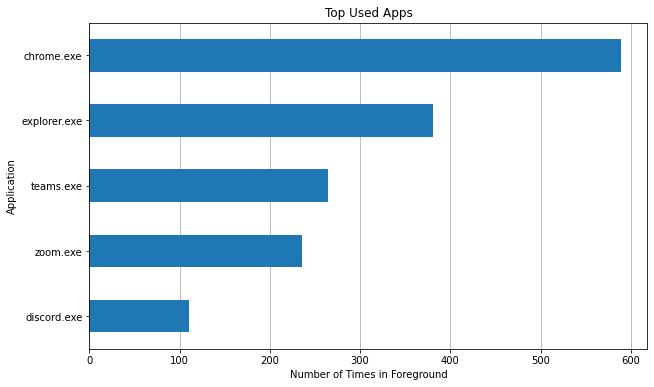

In [6]:
plt.rcParams["figure.figsize"] = (10, 6)
ax = df_string['VALUE'].value_counts()[:5].plot.barh(x = 'index', y = 'VALUE')
ax.set_axisbelow(True)
ax.set_xlabel('Number of Times in Foreground')
ax.set_ylabel('Application')
ax.set_title('Top Used Apps')
ax.invert_yaxis()
plt.grid(axis = 'x')
plt.show()

In [7]:
num_apps = len(df_string[df_string['ID_INPUT'] == 3]['VALUE'].unique())
print('Number of Applications: ' + str(num_apps))

Number of Applications: 68


In [8]:
df_string['MEASUREMENT_TIME'].min()

Timestamp('2021-11-30 22:14:49.985000')

In [9]:
df_string['MEASUREMENT_TIME'].max() # amount 2 month period

Timestamp('2022-01-30 21:54:23.003000')

## HMM

In [10]:
df = df_string

In [11]:
def getPred(numExe, pairProb, start='s0'):
    """
    Predicts laptop foreground window for a specfied number of exe and starting exe
    """
    pred = [start]
    for action in range(numExe-1):
        prev = pred[-1]
        max_prob = 0
        new_exe = ''
        for k in pairProb.keys(): # Finds the most likely following exe given the previous
            if k[0] == prev and pairProb[k] > max_prob:
                new_exe = k[1]
                max_prob = pairProb[k]
        if new_exe == '': # If the exe was not in the training data return the most common exe
            new_exe = 'chrome.exe'
        pred.append(new_exe)
    return pred

In [12]:
def model(df):
    """
    Prints the accuracy for the generated HMM using our data and a 80/20 train test split
    This will differ everytime due to randomization in the data split
    Returns a probility matrix
    """
    # groups data into sequential pairs
    allPairs = []
    for i in range(df.shape[0]-1):
        pair = (df.iloc[i]['VALUE'], df.iloc[i+1]['VALUE'])
        allPairs.append(pair)
    
    # split the data with x being the first part of the pair and y being the second
    X = np.array([x[0] for x in allPairs])
    y = np.array([x[1] for x in allPairs])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) # 80-20 train test split

    # collects unique pair frequency
    pairCountTrain = defaultdict(int)
    for i in range(len(X_train)):
        pair = (X_train[i], y_train[i])
        pairCountTrain[pair] += 1
        
    # collects unique pair proability of appearing given the first exe
    pairProb = defaultdict(int)
    for pair in pairCountTrain:
        b_count = sum(X_train == pair[0])
        pairProb[pair] = pairCountTrain[pair] / b_count # P(A|B)
        
    exes = df['VALUE'].unique()

    # calculate accuracy
    outcome = []
    for i in range(len(X_test)):
        pred = getPred(2, pairProb, X_test[i])
        outcome.append(pred[1] == y_test[i])
    acc = (np.sum(outcome) / len(outcome)) * 100
    
    print('Accuracy is ' + str(acc) + '%')
    
    # create transition matrix
    all_exe = np.unique(X_train) # gather all unique .exe
    prob = [] # values for dataframe

    # i = event B
    for i in all_exe:
        temp_list = []
        # j = event A
        for j in all_exe:
            exe_set = (i, j) # create a set

            try: # see if the set is in one of the pairings
                temp_list.append(pairProb[exe_set])
            except: # if set is not in pairing, then the probability is 0
                temp_list.append(0)

        prob.append(temp_list)

    prob_matrix = pd.DataFrame(prob, index = all_exe, columns = all_exe)
    return prob_matrix

In [13]:
prob_matrix = model(df)

Accuracy is 34.41295546558704%


In [14]:
prob_matrix

,accountscontrolhost.exe,admin app,alertviewer.exe,applicationframehost.exe,chrome.exe,clustertruck.exe,cmd.exe,code.exe,conda.exe,db browser for sqlite.exe,...,teams.exe,time.exe,ts4_x64.exe,uihost.exe,utility.exe,vpnui.exe,werfault.exe,xboxidp.exe,xboxpcapp.exe,zoom.exe
accountscontrolhost.exe,0,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,1.000000,0.000000,0.000000
admin app,0,0.111111,0.00000,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.111111,0.000000,0.111111,0.000000
alertviewer.exe,0,0.000000,0.00000,0.00000,0.500000,0.000000,0.00000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.500000
applicationframehost.exe,0,0.142857,0.00000,0.00000,0.142857,0.000000,0.00000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.071429,0.000000,0.000000
chrome.exe,0,0.002160,0.00216,0.00216,0.000000,0.000000,0.00216,0.0,0.00216,0.0,...,0.213823,0.021598,0.0,0.008639,0.0,0.0,0.000000,0.000000,0.012959,0.235421
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vpnui.exe,0,0.000000,0.00000,0.00000,0.444444,0.000000,0.00000,0.0,0.00000,0.0,...,0.222222,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
werfault.exe,0,0.000000,0.00000,0.00000,0.000000,1.000000,0.00000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000
xboxidp.exe,0,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.333333,0.000000
xboxpcapp.exe,0,0.000000,0.00000,0.00000,0.210526,0.052632,0.00000,0.0,0.00000,0.0,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.052632,0.000000,0.000000


## LSTM RNN Data Preprocessing

### Creating the USE_TIME Variable

In [15]:
df_string.head()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA
0,2021-11-30 22:14:49.985,3,s0,0
1,2021-11-30 22:14:49.985,3,explorer.exe,0
2,2021-11-30 22:14:51.011,3,esrv.exe,0
3,2021-11-30 22:14:51.522,3,teams.exe,0
4,2021-11-30 22:14:52.551,3,esrv.exe,0


In [16]:
# calculate use time in seconds
df_string_cleaned = df_string.copy()
df_string_cleaned['USE_TIME'] = df_string_cleaned['MEASUREMENT_TIME'].diff().dt.total_seconds()

In [17]:
# Set start points to 0 use time and shift the use time up
df_string_cleaned['USE_TIME'] = (df_string_cleaned['VALUE'] != 's0').astype('int64') * df_string_cleaned['USE_TIME']
df_string_cleaned['USE_TIME'] = df_string_cleaned['USE_TIME'].shift(periods=-1)

In [18]:
# clean any remaining null values out
df_string_cleaned['USE_TIME'] = df_string_cleaned['USE_TIME'].fillna(0)

In [19]:
df_string_cleaned.head()

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,USE_TIME
0,2021-11-30 22:14:49.985,3,s0,0,0.000
1,2021-11-30 22:14:49.985,3,explorer.exe,0,1.026
2,2021-11-30 22:14:51.011,3,esrv.exe,0,0.511
3,2021-11-30 22:14:51.522,3,teams.exe,0,1.029
4,2021-11-30 22:14:52.551,3,esrv.exe,0,0.589


Cleaning USE_TIME Outliers

In [20]:
# Noticed suspicious values in this list
df_string_cleaned.groupby('VALUE')['USE_TIME'].sum().sort_values(ascending = False)[:10]

VALUE
explorer.exe              215925.938
chrome.exe                112139.544
msedgewebview2.exe         40755.026
zoom.exe                   30848.950
teams.exe                  24718.179
xboxpcapp.exe              11234.501
red-win64-shipping.exe     10032.482
ts4_x64.exe                 6810.709
eadesktop.exe               5788.924
donutcounty.exe             5590.805
Name: USE_TIME, dtype: float64

In [21]:
out = df_string_cleaned[df_string_cleaned['VALUE'] == 'explorer.exe']['USE_TIME'].sort_values(ascending=False)[1312]
print ('Huge Outlier at 1312 of ' + str(round(out)) + ' minutes for explorer.exe')

Huge Outlier at 1312 of 213399 minutes for explorer.exe


In [22]:
df_string_cleaned.loc[1310:1315, :]

,MEASUREMENT_TIME,ID_INPUT,VALUE,PRIVATE_DATA,USE_TIME
1311,2021-12-10 01:30:32.678,3,s0,0,0.000
1312,2021-12-10 01:30:32.678,3,explorer.exe,0,213398.946
1313,2021-12-12 12:47:11.624,3,lockapp.exe,0,14.618
1314,2021-12-12 12:47:26.242,3,explorer.exe,0,0.628
1315,2021-12-12 12:47:26.870,3,microsoft.aad.brokerplugin.exe,0,18.863


In [23]:
df_string_cleaned.drop(1312, inplace=True)

In [24]:
# msedgewebview2.exe has a huge outlier that needs to be dropped
out = df_string_cleaned.loc[2009, :]['USE_TIME']
print ('Huge Outlier at 2009 of ' + str(round(out)) + 'seconds for msedgewebview2.exe')

Huge Outlier at 2009 of 39924seconds for msedgewebview2.exe


In [25]:
df_string_cleaned.drop(2009, inplace=True)

In [26]:
use_time = df_string_cleaned.groupby('VALUE')['USE_TIME'].sum().sort_values(ascending = False)
use_time[:5]

VALUE
chrome.exe                112139.544
zoom.exe                   30848.950
teams.exe                  24718.179
xboxpcapp.exe              11234.501
red-win64-shipping.exe     10032.482
Name: USE_TIME, dtype: float64

USE_TIME Plots

In [27]:
top_apps = use_time[:5]
top_apps.index = pd.Index(['Chrome', 'Zoom', 'Teams', 'Xbox App', 'Dragon Ball FighterZ'])
top_apps = top_apps / 60 / 60

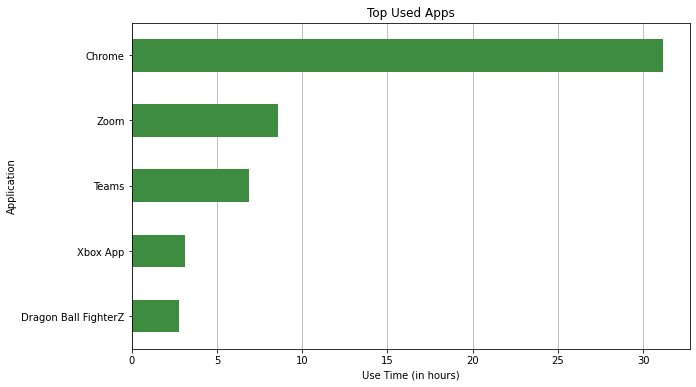

In [28]:
ax = top_apps.plot.barh(color = '#3D8C40')
ax.set_axisbelow(True)
ax.set_xlabel('Use Time (in hours)')
ax.set_ylabel('Application')
ax.set_title('Top Used Apps')
ax.invert_yaxis()
plt.grid(axis = 'x')
plt.show()

In [29]:
df = df_string_cleaned.drop(['ID_INPUT', 'VALUE', 'PRIVATE_DATA'], axis=1)

In [30]:
first_bin, last_bin = df['MEASUREMENT_TIME'].min(), df['MEASUREMENT_TIME'].max()
delta = last_bin - first_bin
delta

Timedelta('60 days 23:39:33.018000')

In [31]:
n_bins = delta.days + 2
bins = []
for i in range(n_bins):
    day = first_bin + timedelta(days=i)
    bins.append(day)

In [32]:
df['MEASUREMENT_TIME'] = pd.cut(df['MEASUREMENT_TIME'], bins=bins, right=False)
df = df.groupby('MEASUREMENT_TIME').sum()
df.reset_index(inplace=True)
df.head()

,MEASUREMENT_TIME,USE_TIME
0,"[2021-11-30 22:14:49.985000, 2021-12-01 22:14:...",14291.223
1,"[2021-12-01 22:14:49.985000, 2021-12-02 22:14:...",7682.393
2,"[2021-12-02 22:14:49.985000, 2021-12-03 22:14:...",3111.169
3,"[2021-12-03 22:14:49.985000, 2021-12-04 22:14:...",0.000
4,"[2021-12-04 22:14:49.985000, 2021-12-05 22:14:...",0.000


In [33]:
MAXIMUM_SECONDS = 3600 * 24 # 3600 seconds in an hour
use_time = list(df['USE_TIME'])

for i in range(len(use_time) - 1):
    row = use_time[i]
    next_row = use_time[i + 1]
    
    if row > MAXIMUM_SECONDS:
        rollover = row - MAXIMUM_SECONDS
        row = MAXIMUM_SECONDS
        next_row += rollover
        use_time[i] = row
        use_time[i + 1] = next_row

In [34]:
df['MEASUREMENT_TIME'] = df.apply(lambda x: x['MEASUREMENT_TIME'].left, axis=1)

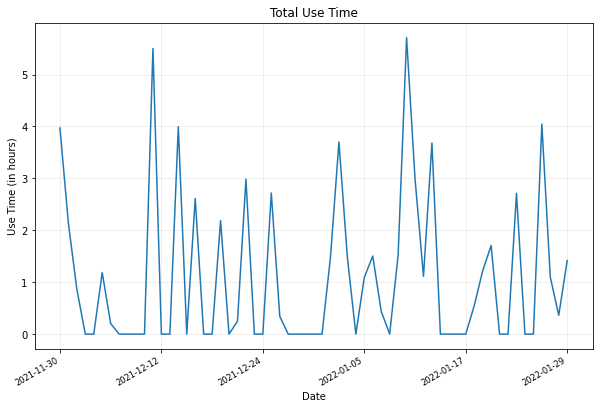

In [35]:
major_ticks = [
               df['MEASUREMENT_TIME'][0], df['MEASUREMENT_TIME'][12], df['MEASUREMENT_TIME'][24], df['MEASUREMENT_TIME'][36],
               df['MEASUREMENT_TIME'][48], df['MEASUREMENT_TIME'][60]
              ]

ax = plt.subplot()
ax.plot(df['MEASUREMENT_TIME'], df['USE_TIME'] / 60 / 60)
ax.set_axisbelow(True)
ax.set_xticks(major_ticks)
ax.set_xlabel('Date')
ax.set_ylabel('Use Time (in hours)')
ax.set_title('Total Use Time')
ax.grid(alpha=0.25)
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='small')
plt.show()

### Other Variables

In [36]:
chrome = df_string_cleaned[df_string_cleaned['VALUE'] == 'chrome.exe']
chrome = chrome.drop(['ID_INPUT', 'VALUE', 'PRIVATE_DATA'], axis=1)
chrome.head()

,MEASUREMENT_TIME,USE_TIME
48,2021-12-01 12:54:25.797,169.566
54,2021-12-01 12:57:16.380,3.160
60,2021-12-01 12:57:21.605,159.664
66,2021-12-01 13:00:31.920,93.454
72,2021-12-01 13:02:12.028,75.076


In [37]:
# ON_BREAK is when the data takes place during UCSD's Winter Break
break_start = pd.to_datetime('2021-12-11 00:00:00')
break_end = pd.to_datetime('2022-01-02 23:59:59')
chrome['ON_BREAK'] = chrome['MEASUREMENT_TIME'].between(break_start, break_end).astype('int64')
chrome.head()

,MEASUREMENT_TIME,USE_TIME,ON_BREAK
48,2021-12-01 12:54:25.797,169.566,0
54,2021-12-01 12:57:16.380,3.160,0
60,2021-12-01 12:57:21.605,159.664,0
66,2021-12-01 13:00:31.920,93.454,0
72,2021-12-01 13:02:12.028,75.076,0


In [38]:
first_bin, last_bin = chrome['MEASUREMENT_TIME'].min(), chrome['MEASUREMENT_TIME'].max()
delta = last_bin - first_bin
delta

Timedelta('60 days 08:40:41.866000')

In [39]:
n_bins = (delta.seconds // 3600) + (delta.days * 24)
bins = []
for i in range(n_bins):
    hour = first_bin + timedelta(hours=i)
    bins.append(hour)

In [40]:
chrome['MEASUREMENT_TIME'] = pd.cut(chrome['MEASUREMENT_TIME'], bins=bins, right=False)
chrome = chrome.groupby('MEASUREMENT_TIME').sum()
chrome.reset_index(inplace=True)
chrome.head()

,MEASUREMENT_TIME,USE_TIME,ON_BREAK
0,"[2021-12-01 12:54:25.797000, 2021-12-01 13:54:...",1896.17,0
1,"[2021-12-01 13:54:25.797000, 2021-12-01 14:54:...",0.00,0
2,"[2021-12-01 14:54:25.797000, 2021-12-01 15:54:...",0.00,0
3,"[2021-12-01 15:54:25.797000, 2021-12-01 16:54:...",0.00,0
4,"[2021-12-01 16:54:25.797000, 2021-12-01 17:54:...",0.00,0


In [41]:
# Some values are too high because use_times over nan hour weren't accounted for
chrome.iloc[380:390]

,MEASUREMENT_TIME,USE_TIME,ON_BREAK
380,"[2021-12-17 08:54:25.797000, 2021-12-17 09:54:...",0.000,0
381,"[2021-12-17 09:54:25.797000, 2021-12-17 10:54:...",0.000,0
382,"[2021-12-17 10:54:25.797000, 2021-12-17 11:54:...",0.000,0
383,"[2021-12-17 11:54:25.797000, 2021-12-17 12:54:...",0.000,0
384,"[2021-12-17 12:54:25.797000, 2021-12-17 13:54:...",160.361,5
385,"[2021-12-17 13:54:25.797000, 2021-12-17 14:54:...",9087.703,4
386,"[2021-12-17 14:54:25.797000, 2021-12-17 15:54:...",0.000,0
387,"[2021-12-17 15:54:25.797000, 2021-12-17 16:54:...",3.581,1
388,"[2021-12-17 16:54:25.797000, 2021-12-17 17:54:...",0.000,0
389,"[2021-12-17 17:54:25.797000, 2021-12-17 18:54:...",0.000,0


In [42]:
MAXIMUM_SECONDS = 3600 # 3600 seconds in an hour
use_time = list(chrome['USE_TIME'])

for i in range(len(use_time) - 1):
    row = use_time[i]
    next_row = use_time[i + 1]
    
    if row > MAXIMUM_SECONDS:
        rollover = row - MAXIMUM_SECONDS
        row = MAXIMUM_SECONDS
        next_row += rollover
        use_time[i] = row
        use_time[i + 1] = next_row

In [43]:
chrome['USE_TIME'] = use_time
chrome.iloc[380:390]

,MEASUREMENT_TIME,USE_TIME,ON_BREAK
380,"[2021-12-17 08:54:25.797000, 2021-12-17 09:54:...",0.000,0
381,"[2021-12-17 09:54:25.797000, 2021-12-17 10:54:...",0.000,0
382,"[2021-12-17 10:54:25.797000, 2021-12-17 11:54:...",0.000,0
383,"[2021-12-17 11:54:25.797000, 2021-12-17 12:54:...",0.000,0
384,"[2021-12-17 12:54:25.797000, 2021-12-17 13:54:...",160.361,5
385,"[2021-12-17 13:54:25.797000, 2021-12-17 14:54:...",3600.000,4
386,"[2021-12-17 14:54:25.797000, 2021-12-17 15:54:...",3600.000,0
387,"[2021-12-17 15:54:25.797000, 2021-12-17 16:54:...",1891.284,1
388,"[2021-12-17 16:54:25.797000, 2021-12-17 17:54:...",0.000,0
389,"[2021-12-17 17:54:25.797000, 2021-12-17 18:54:...",0.000,0


In [44]:
chrome['MEASUREMENT_TIME'] = range(chrome.shape[0])

In [45]:
chrome['ON_BREAK'] = chrome['ON_BREAK'].apply(lambda x: 1 if x > 0 else 0)

In [46]:
chrome.head()

,MEASUREMENT_TIME,USE_TIME,ON_BREAK
0,0,1896.17,0
1,1,0.00,0
2,2,0.00,0
3,3,0.00,0
4,4,0.00,0


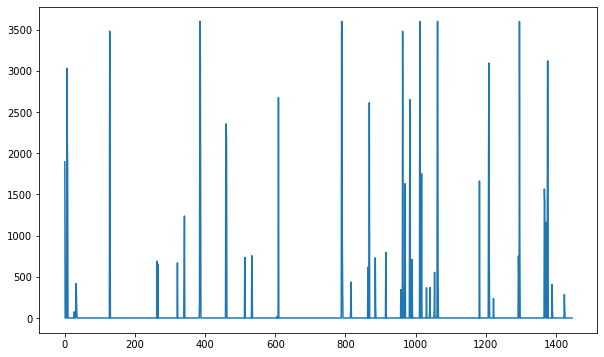

In [47]:
plt.plot(chrome['MEASUREMENT_TIME'], chrome['USE_TIME'])

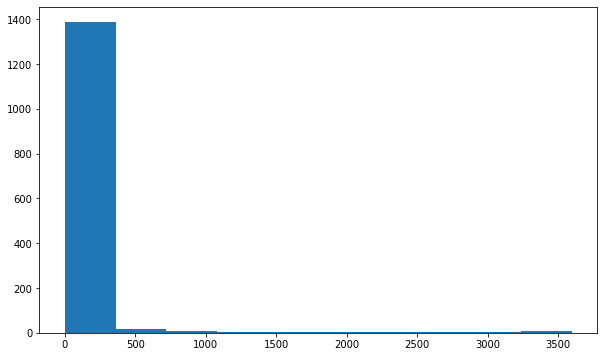

In [48]:
plt.hist(chrome['USE_TIME']) # lot's of zeroes for use_time
plt.show()

In [49]:
df = {'h1': [], 'h2': [], 'h3': [], 'h4': [], 'h5': [], 'h6': [], 'h7': [], 'h8': [], 'h9': [], 'h10': [], 'h11': [], 'h12': [],
      'h13': [], 'h14': [], 'h15': [], 'h16': [], 'h17': [], 'h18': [], 'h19': [], 'h20': [], 'h21': [], 'h22': [], 'h23': [], 'h24': []}
starts = list(range(0, 1448, 24))
for start in starts:
    for i in range(24):
        indx = i + start
        key = list(df.keys())[i]
        if indx < chrome.shape[0]:
            df[key].append(chrome.iloc[indx]['USE_TIME'])
        else:
            df[key].append(0)

In [50]:
day_chrome = pd.DataFrame(df)
day_chrome['day_use'] = day_chrome.sum(axis=1)
day_chrome

,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h16,h17,h18,h19,h20,h21,h22,h23,h24,day_use
0,1896.170,0.000,0.0,0.000,0.000,0.000,3031.022,2209.002,1849.303,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,8985.497
1,0.000,0.000,0.0,74.634,0.000,0.000,0.000,44.355,417.036,287.859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,907.139
2,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000
3,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000
4,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,1565.922,1565.922
57,1408.135,86.956,0.0,0.000,1155.694,1161.268,0.000,0.000,3122.113,3115.908,...,0.0,0.0,0.0,0.0,0.0,0.0,407.67,89.983,0.000,10547.727
58,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000
59,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,285.175,102.912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,388.087


## LSTM Building

### Encoding 1

In [51]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
chrome['SCALED_USE_TIME'] = scaler.fit_transform(np.array(chrome['USE_TIME']).reshape(-1, 1))
dataset = np.array(chrome.loc[:, ['SCALED_USE_TIME', 'ON_BREAK']])

In [52]:
lookback = 3

In [53]:
# split into train and test sets, we want it sequential
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1157 290


In [54]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [55]:
def basic_LSTM(lookback, num_inputs = 1, epochs = 100, batch_size = 1, verbose = 2, loss = 'mean_squared_error', optimizer = 'adam', density = 1):
    '''
    Creates and returns a basic LSTM model given a series of hyperparameters
    All are defaulted except lookback, which is the number of inputs used to predict the outputs
    
    *** Lookback must be greater than 1
    '''
    trainX, trainY = create_dataset(train, lookback)
    testX, testY = create_dataset(test, lookback)
    
    # reshape input to be [samples, time steps, features]
    trainX = np.reshape(trainX, (trainX.shape[0], num_inputs, trainX.shape[1]))
    testX = np.reshape(testX, (testX.shape[0], num_inputs, testX.shape[1]))
    
    # create and fit the LSTM network
    model = Sequential()
    model.add(LSTM(4, input_shape=(num_inputs, lookback)))
    for i in range(density):
        model.add(Dense(1))
    model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
    model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = verbose)
    
    # make predictions
    trainPredict = model.predict(trainX)
    testPredict = model.predict(testX)
    # invert predictions
    trainPredict = scaler.inverse_transform(trainPredict)
    trainY = scaler.inverse_transform([trainY])
    testPredict = scaler.inverse_transform(testPredict)
    testY = scaler.inverse_transform([testY])
    # calculate root mean squared error
    trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
    print('Test Score: %.2f RMSE' % (testScore))
    
    # shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(trainPredict)+(lookback*2)+1:len(dataset)-1, :] = testPredict
    # plot baseline and predictions
    fig, ax = plt.subplots()
    ax.plot(scaler.inverse_transform(dataset[len(trainY[0]):, 0].reshape(-1, 1)), label = 'Dataset')
    ax.set_xlabel('Hour')
    ax.set_ylabel('Use Time (seconds)')
    ax.set_title('Initial Model Prediction')
    #ax.plot(trainPredictPlot, label = 'Train Prediction')
    ax.plot(testPredict, label = 'Test Prediction')
    ax.legend()
    plt.show()
    
    return model, testPredict, testY

In [56]:
def calculate_accuracy(prediction, actual, threshold = .5):
    '''
    Custom accuracy function to test our models
    Instead of 1:1 calculation from keras, this function will accept a threshold instead of exact value
    '''
    accurate = []
    prediction = prediction - prediction[0]
    
    for i in range(len(actual)):
        if actual[i] == 0: # edge case
            left_bound = float('-inf')
            right_bound = threshold
        else:
            left_bound = actual[i] - (actual[i] * threshold)
            right_bound = (actual[i] * threshold) + actual[i]
        
        if left_bound <= prediction[i] <= right_bound:
            accurate.append(1)
        else:
            accurate.append(0)
            
    return np.mean(accurate)

Epoch 1/100
577/577 - 2s - loss: 0.0127 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0126 - accuracy: 0.9454 - 745ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0127 - accuracy: 0.9454 - 696ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0126 - accuracy: 0.9454 - 639ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0125 - accuracy: 0.9454 - 629ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0125 - accuracy: 0.9454 - 633ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0125 - accuracy: 0.9454 - 693ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0125 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0125 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0123 - accuracy: 0.9454 - 742ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0124 - accuracy: 0.9454 - 769ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0123 - accuracy: 0.9454 - 671ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0112 - accuracy: 0.9454 - 630ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0110 - accuracy: 0.9454 - 627ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0110 - accuracy: 0.9454 - 630ms/epoch - 1ms/step
Train Score: 376.44 RMSE
Test Score: 412.15 RMSE


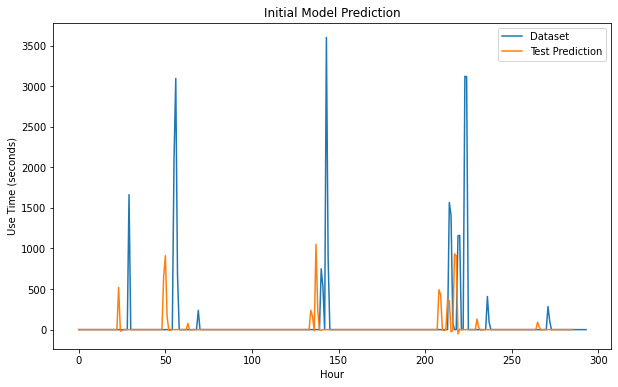

Epoch 1/100
577/577 - 2s - loss: 0.0129 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 668ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 658ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0128 - accuracy: 0.9454 - 654ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0127 - accuracy: 0.9454 - 664ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0125 - accuracy: 0.9454 - 680ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0124 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 674ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0120 - accuracy: 0.9454 - 678ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0120 - accuracy: 0.9454 - 684ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0118 - accuracy: 0.9454 - 663ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0117 - accuracy: 0.9454 - 664ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0106 - accuracy: 0.9454 - 654ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0107 - accuracy: 0.9454 - 659ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0106 - accuracy: 0.9454 - 655ms/epoch - 1ms/step
Train Score: 365.04 RMSE
Test Score: 401.32 RMSE


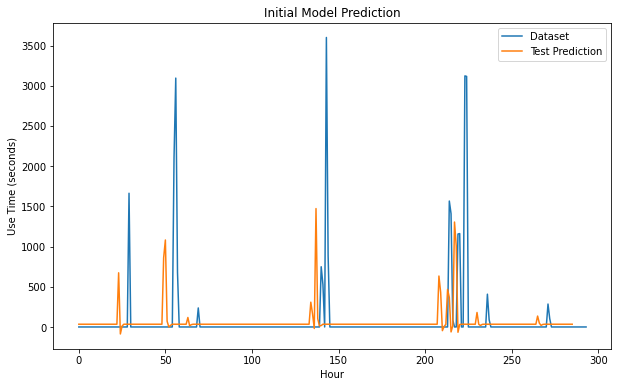

Epoch 1/100
577/577 - 2s - loss: 0.0129 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0128 - accuracy: 0.9454 - 678ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0125 - accuracy: 0.9454 - 680ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0121 - accuracy: 0.9454 - 684ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0118 - accuracy: 0.9454 - 685ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0114 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0112 - accuracy: 0.9454 - 681ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0108 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0106 - accuracy: 0.9454 - 685ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0105 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0103 - accuracy: 0.9454 - 681ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0103 - accuracy: 0.9462 - 680ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0095 - accuracy: 0.9480 - 684ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0095 - accuracy: 0.9480 - 681ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0096 - accuracy: 0.9471 - 677ms/epoch - 1ms/step
Train Score: 347.01 RMSE
Test Score: 390.95 RMSE


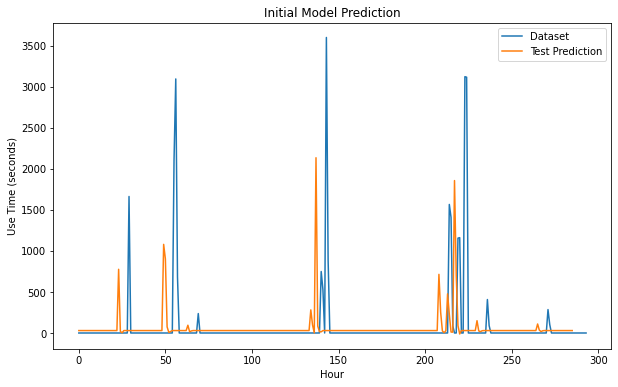

Epoch 1/100
577/577 - 3s - loss: 0.0122 - accuracy: 0.9454 - 3s/epoch - 5ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 656ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 659ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 670ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 656ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 657ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 660ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 656ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 657ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 662ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 657ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 663ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0121 - accuracy: 0.9454 - 663ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0121 - accuracy: 0.9454 - 657ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0121 - accuracy: 0.9454 - 660ms/epoch - 1ms/step
Train Score: 395.90 RMSE
Test Score: 437.19 RMSE


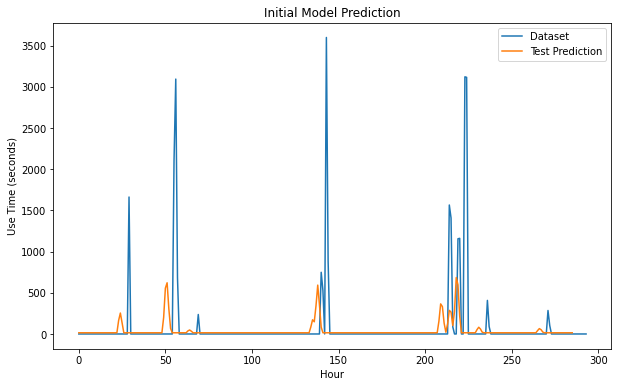

Epoch 1/100
577/577 - 2s - loss: 0.0132 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0131 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 663ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 664ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 672ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 672ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 670ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 666ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 664ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 664ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 650ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 649ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 657ms/epoch - 1ms/step
Train Score: 409.56 RMSE
Test Score: 445.40 RMSE


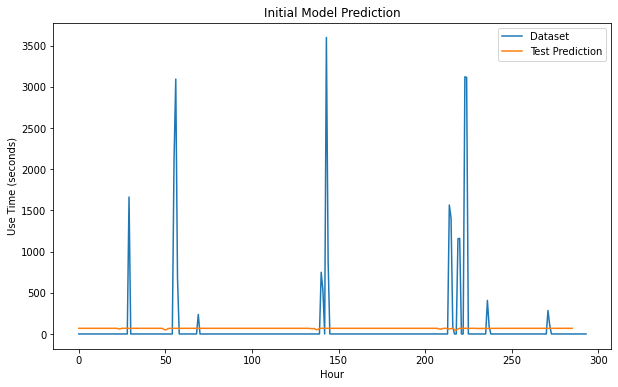

Epoch 1/100
577/577 - 2s - loss: 0.0128 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0125 - accuracy: 0.9454 - 669ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0124 - accuracy: 0.9454 - 667ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 662ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0121 - accuracy: 0.9454 - 726ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0120 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0119 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0118 - accuracy: 0.9454 - 667ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0118 - accuracy: 0.9454 - 667ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0117 - accuracy: 0.9454 - 667ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0116 - accuracy: 0.9454 - 670ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0116 - accuracy: 0.9454 - 668ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0099 - accuracy: 0.9462 - 660ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0099 - accuracy: 0.9462 - 661ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0099 - accuracy: 0.9462 - 661ms/epoch - 1ms/step
Train Score: 357.16 RMSE
Test Score: 400.19 RMSE


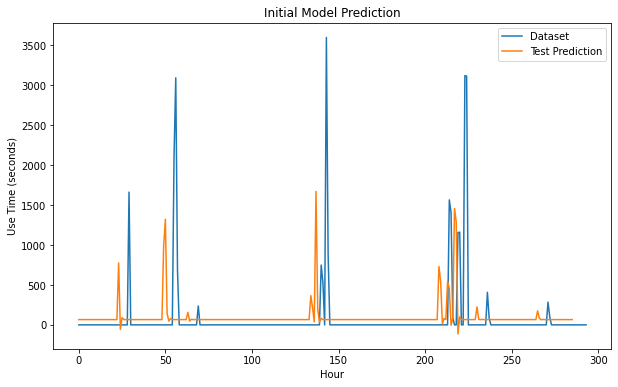

Epoch 1/100
577/577 - 3s - loss: 0.0129 - accuracy: 0.9454 - 3s/epoch - 5ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0126 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0122 - accuracy: 0.9454 - 689ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0117 - accuracy: 0.9454 - 689ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0113 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0109 - accuracy: 0.9454 - 693ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0106 - accuracy: 0.9454 - 689ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0106 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0104 - accuracy: 0.9454 - 694ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0103 - accuracy: 0.9454 - 701ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0103 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0102 - accuracy: 0.9462 - 695ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0097 - accuracy: 0.9480 - 696ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0096 - accuracy: 0.9480 - 694ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0096 - accuracy: 0.9480 - 694ms/epoch - 1ms/step
Train Score: 348.00 RMSE
Test Score: 389.85 RMSE


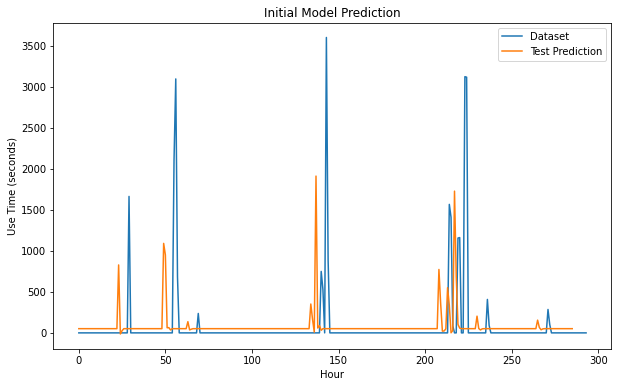

Epoch 1/100
577/577 - 2s - loss: 0.0131 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0130 - accuracy: 0.9454 - 727ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 836ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 878ms/epoch - 2ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 752ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 809ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 743ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 748ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 731ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 791ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 805ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 712ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 724ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 737ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0129 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Train Score: 408.37 RMSE
Test Score: 444.49 RMSE


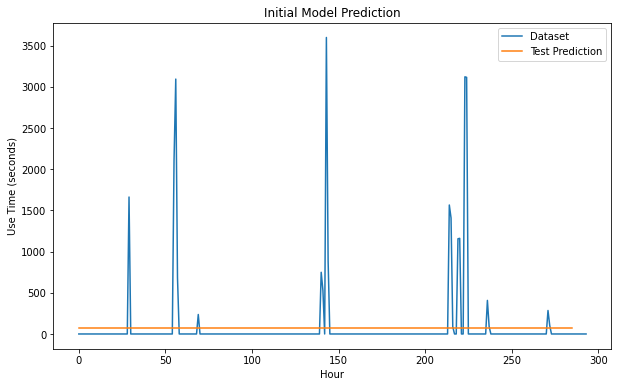

Epoch 1/100
577/577 - 2s - loss: 0.0238 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0239 - accuracy: 0.9454 - 748ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0238 - accuracy: 0.9454 - 779ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0238 - accuracy: 0.9454 - 790ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0238 - accuracy: 0.9454 - 740ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0239 - accuracy: 0.9454 - 745ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0238 - accuracy: 0.9454 - 701ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0239 - accuracy: 0.9454 - 721ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0238 - accuracy: 0.9454 - 730ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0238 - accuracy: 0.9454 - 746ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0238 - accuracy: 0.9454 - 964ms/epoch - 2ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0239 - accuracy: 0.9454 - 970ms/epoch - 2

Epoch 98/100
577/577 - 1s - loss: 0.0238 - accuracy: 0.9454 - 637ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0239 - accuracy: 0.9454 - 645ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0238 - accuracy: 0.9454 - 642ms/epoch - 1ms/step
Train Score: 416.80 RMSE
Test Score: 456.34 RMSE


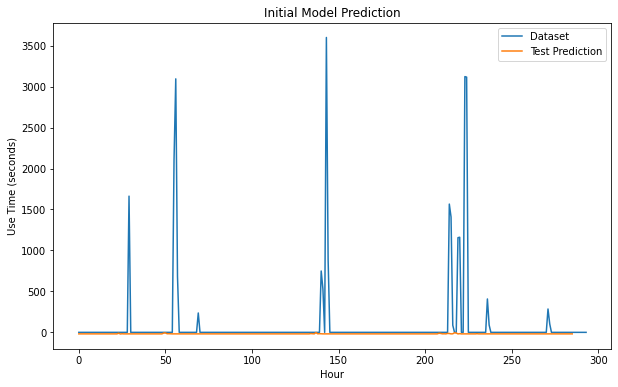

Epoch 1/100
577/577 - 2s - loss: 0.0200 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 673ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 666ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 668ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 668ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 667ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 669ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 676ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 668ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 672ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 674ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 679ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0196 - accuracy: 0.9454 - 671ms/epoch - 1ms/step
Train Score: 414.04 RMSE
Test Score: 453.07 RMSE


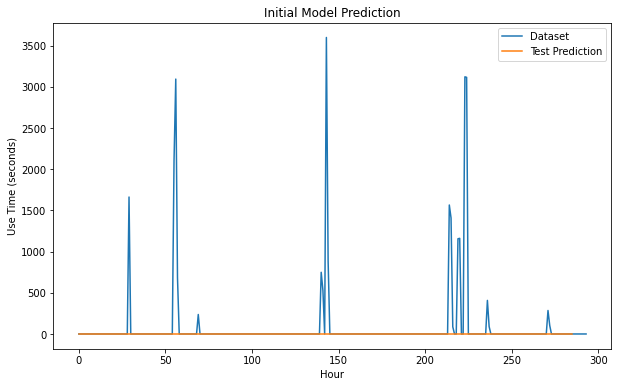

Epoch 1/100
577/577 - 2s - loss: 0.0197 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0195 - accuracy: 0.9454 - 666ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0194 - accuracy: 0.9454 - 667ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0194 - accuracy: 0.9454 - 739ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 739ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 778ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 762ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 723ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 673ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 676ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 675ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 677ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0180 - accuracy: 0.9454 - 666ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0180 - accuracy: 0.9454 - 666ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0180 - accuracy: 0.9454 - 673ms/epoch - 1ms/step
Train Score: 371.20 RMSE
Test Score: 417.69 RMSE


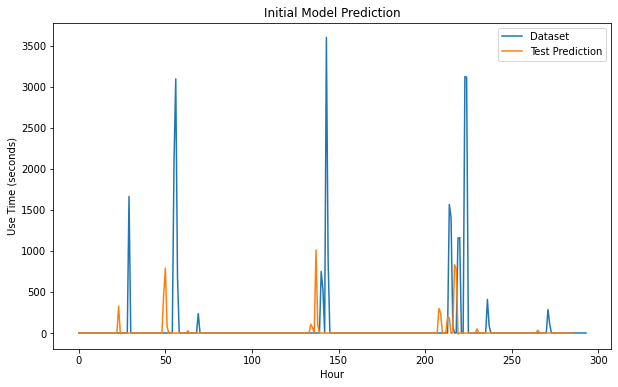

Epoch 1/100
577/577 - 2s - loss: 0.0404 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0404 - accuracy: 0.9454 - 664ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0404 - accuracy: 0.9454 - 667ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0404 - accuracy: 0.9454 - 663ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0403 - accuracy: 0.9454 - 663ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0403 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0403 - accuracy: 0.9454 - 670ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0403 - accuracy: 0.9454 - 662ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0403 - accuracy: 0.9454 - 664ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0402 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0402 - accuracy: 0.9454 - 664ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0402 - accuracy: 0.9454 - 671ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0385 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0385 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0385 - accuracy: 0.9454 - 662ms/epoch - 1ms/step
Train Score: 583.15 RMSE
Test Score: 561.97 RMSE


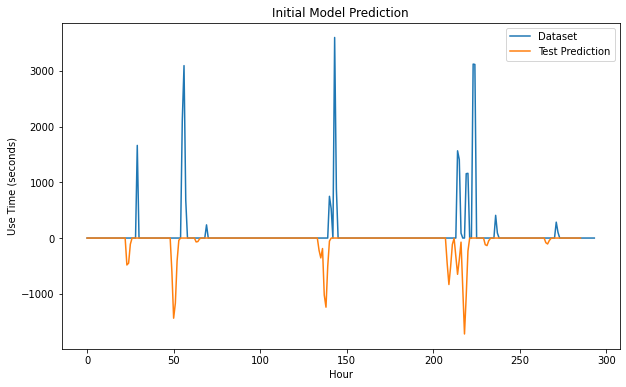

Epoch 1/100
577/577 - 2s - loss: 0.0211 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0210 - accuracy: 0.9454 - 659ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0209 - accuracy: 0.9454 - 659ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0209 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0209 - accuracy: 0.9454 - 673ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0208 - accuracy: 0.9454 - 658ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0208 - accuracy: 0.9454 - 658ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0208 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0208 - accuracy: 0.9454 - 659ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0207 - accuracy: 0.9454 - 658ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0207 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0207 - accuracy: 0.9454 - 655ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0200 - accuracy: 0.9454 - 680ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0200 - accuracy: 0.9454 - 676ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0200 - accuracy: 0.9454 - 675ms/epoch - 1ms/step
Train Score: 406.34 RMSE
Test Score: 452.35 RMSE


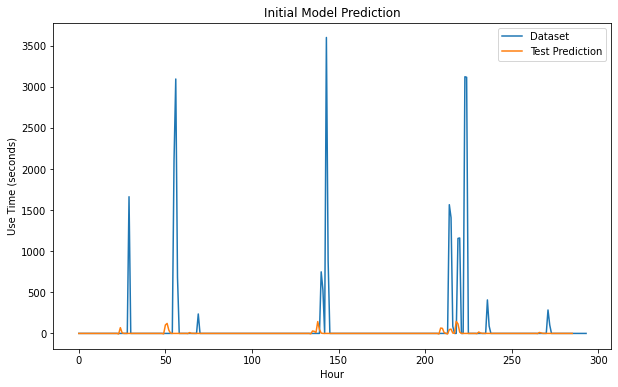

Epoch 1/100
577/577 - 2s - loss: 0.0192 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 702ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 694ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 708ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 700ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0192 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Train Score: 414.13 RMSE
Test Score: 453.20 RMSE


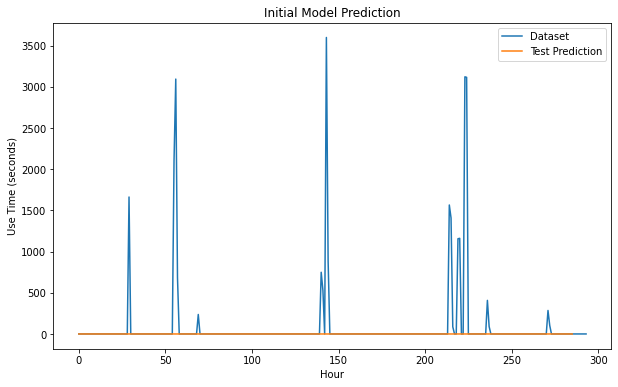

Epoch 1/100
577/577 - 3s - loss: 0.0198 - accuracy: 0.9454 - 3s/epoch - 5ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0195 - accuracy: 0.9454 - 813ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0194 - accuracy: 0.9454 - 724ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0194 - accuracy: 0.9454 - 729ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 726ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 739ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 723ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 735ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 724ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 728ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 724ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0193 - accuracy: 0.9454 - 726ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0179 - accuracy: 0.9454 - 729ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0179 - accuracy: 0.9454 - 733ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0178 - accuracy: 0.9454 - 724ms/epoch - 1ms/step
Train Score: 367.69 RMSE
Test Score: 413.43 RMSE


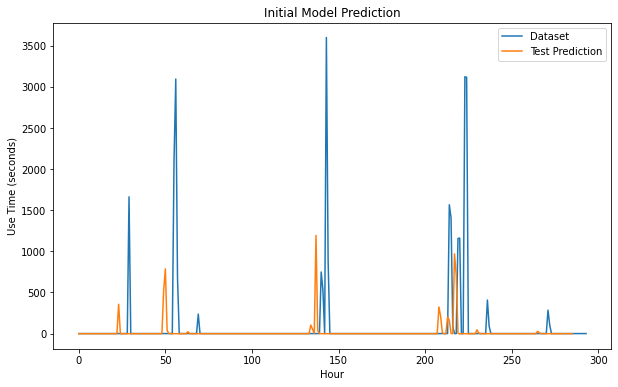

Epoch 1/100
577/577 - 2s - loss: 0.0191 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 693ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 695ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 712ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 694ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 697ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 695ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0191 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Train Score: 414.12 RMSE
Test Score: 453.16 RMSE


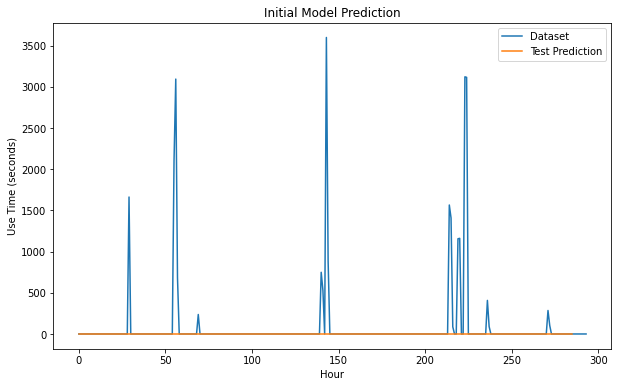

Epoch 1/100
577/577 - 2s - loss: nan - accuracy: 0.9436 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 678ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 674ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 680ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 679ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 679ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 679ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 679ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 676ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: nan - accuracy: 0.9454 - 676ms/epoch - 1ms/step
Epoch 13/100
577/577 - 1s - 

577/577 - 2s - loss: 7965393.0000 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 2041269.6250 - accuracy: 0.9454 - 694ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 876141.0000 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 537216.8750 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 478314.1875 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 479879.0938 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 479936.2188 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 478969.4375 - accuracy: 0.9454 - 688ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 478181.4688 - accuracy: 0.9454 - 688ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 479006.8750 - accuracy: 0.9454 - 685ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 479616.1562 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss

Epoch 93/100
577/577 - 1s - loss: 478401.8438 - accuracy: 0.9454 - 695ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: 478451.1250 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: 478634.9062 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: 478506.4062 - accuracy: 0.9454 - 688ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: 479213.6875 - accuracy: 0.9454 - 689ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: 477638.7188 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 479782.5625 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 477993.4062 - accuracy: 0.9454 - 746ms/epoch - 1ms/step
Train Score: 413.63 RMSE
Test Score: 452.56 RMSE


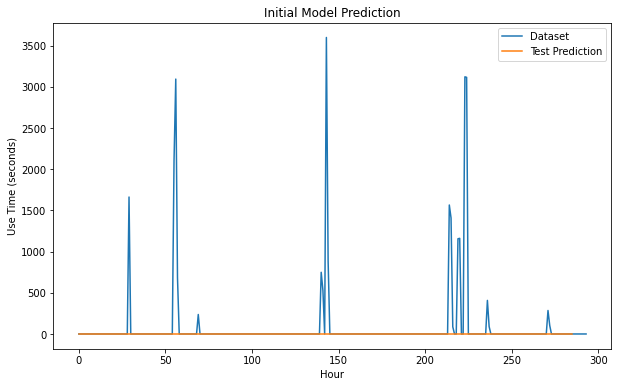

Epoch 1/100
577/577 - 2s - loss: 164443.5469 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 103558.9844 - accuracy: 0.9454 - 701ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 121229.1172 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 170617.9844 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 197582.4531 - accuracy: 0.9454 - 700ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 111547.8828 - accuracy: 0.9454 - 700ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 106009.7500 - accuracy: 0.9454 - 700ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 150572.3438 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 125130.1719 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 90687.7969 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 142488.1719 - accuracy: 0.9454 - 700ms/epoch - 1ms/step
Epoch 12/100
577/577 - 

Epoch 93/100
577/577 - 1s - loss: 126367.9141 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: 121890.2188 - accuracy: 0.9454 - 702ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: 128914.2031 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: 137069.4375 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: 124091.3672 - accuracy: 0.9454 - 702ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: 109836.4844 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 114924.9141 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 98102.9219 - accuracy: 0.9454 - 695ms/epoch - 1ms/step
Train Score: 414.15 RMSE
Test Score: 453.20 RMSE


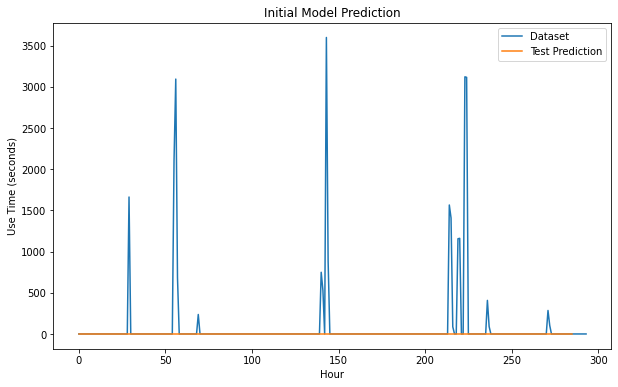

Epoch 1/100
577/577 - 2s - loss: 1356635.8750 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 1356505.6250 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 1356119.5000 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 1355449.3750 - accuracy: 0.9454 - 689ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 1354819.7500 - accuracy: 0.9454 - 688ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 1353983.7500 - accuracy: 0.9454 - 689ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 1353313.7500 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 1352253.6250 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 1351338.1250 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 1350433.7500 - accuracy: 0.9454 - 686ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 1349563.3750 - accuracy: 0.9454 - 686ms/epoch - 1ms/step
Epoch 12/10

Epoch 92/100
577/577 - 1s - loss: 1266949.6250 - accuracy: 0.9454 - 693ms/epoch - 1ms/step
Epoch 93/100
577/577 - 1s - loss: 1265729.3750 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: 1264818.1250 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: 1263794.7500 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: 1262895.0000 - accuracy: 0.9454 - 688ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: 1261755.5000 - accuracy: 0.9454 - 688ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: 1260854.1250 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 1259801.5000 - accuracy: 0.9454 - 696ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 1258783.0000 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Train Score: 412.54 RMSE
Test Score: 449.55 RMSE


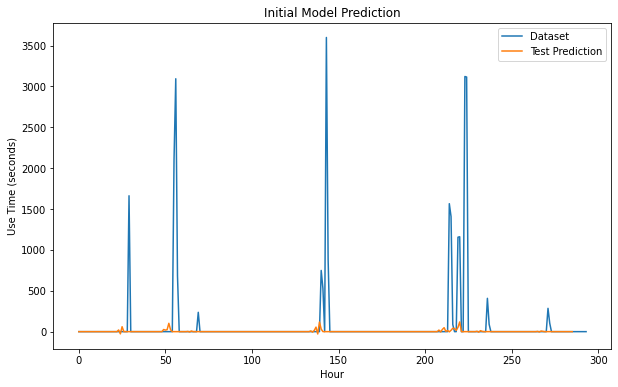

Epoch 1/100
577/577 - 2s - loss: 631297.3750 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 523074.1562 - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 479706.8125 - accuracy: 0.9454 - 676ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 448494.6562 - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 423777.0625 - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 403894.1250 - accuracy: 0.9454 - 680ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 386147.0625 - accuracy: 0.9454 - 683ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 371116.5625 - accuracy: 0.9454 - 676ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 357525.4688 - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 345274.0938 - accuracy: 0.9454 - 675ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 334106.9688 - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: 104615.0312 - accuracy: 0.9454 - 688ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: 103663.2109 - accuracy: 0.9454 - 676ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: 102818.7656 - accuracy: 0.9454 - 678ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: 101954.3828 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: 101132.8750 - accuracy: 0.9454 - 679ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: 100268.7734 - accuracy: 0.9454 - 675ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 99427.4531 - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 98623.7969 - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Train Score: 413.27 RMSE
Test Score: 452.34 RMSE


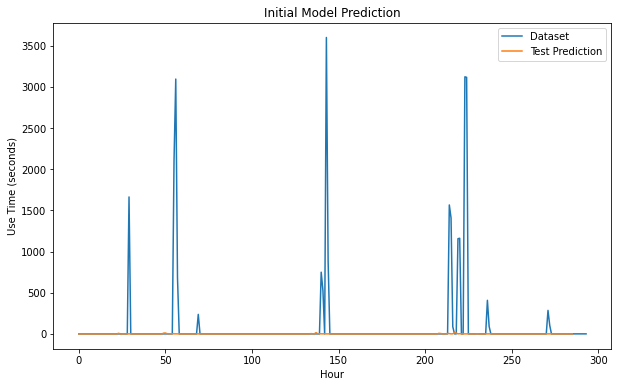

Epoch 1/100
577/577 - 2s - loss: 2462150.5000 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 1631555.3750 - accuracy: 0.9454 - 693ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 1024675.4375 - accuracy: 0.9454 - 695ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 852139.2500 - accuracy: 0.9454 - 694ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 728144.5625 - accuracy: 0.9454 - 694ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 526720.0625 - accuracy: 0.9454 - 695ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 530597.5625 - accuracy: 0.9454 - 695ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 295970.5312 - accuracy: 0.9454 - 693ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 328697.8750 - accuracy: 0.9454 - 689ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 276835.7188 - accuracy: 0.9454 - 693ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 189103.8438 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 12/100
577/57

Epoch 93/100
577/577 - 1s - loss: 114620.7812 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: 131333.2812 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: 108674.6094 - accuracy: 0.9454 - 695ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: 105601.6484 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: 119143.6016 - accuracy: 0.9454 - 695ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: 104473.8438 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 98886.7344 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 105696.9531 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Train Score: 414.05 RMSE
Test Score: 453.08 RMSE


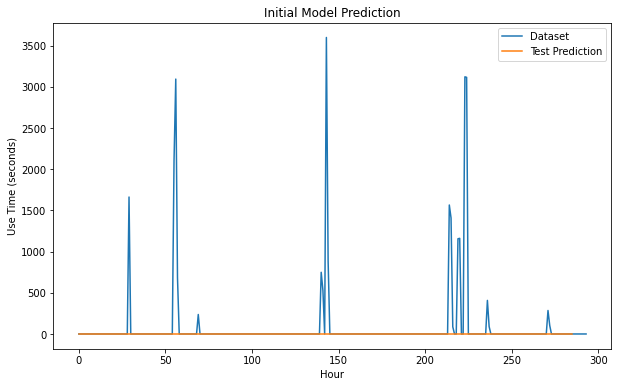

Epoch 1/100
577/577 - 3s - loss: 461092.0000 - accuracy: 0.9454 - 3s/epoch - 5ms/step
Epoch 2/100
577/577 - 1s - loss: 272947.0938 - accuracy: 0.9454 - 743ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 238798.9531 - accuracy: 0.9454 - 762ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 223310.4062 - accuracy: 0.9454 - 749ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 211416.0938 - accuracy: 0.9454 - 744ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 198814.7969 - accuracy: 0.9454 - 745ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 188779.7656 - accuracy: 0.9454 - 765ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 177930.2812 - accuracy: 0.9454 - 747ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 169701.4219 - accuracy: 0.9454 - 743ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 164619.2188 - accuracy: 0.9454 - 746ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 157685.7812 - accuracy: 0.9454 - 754ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: 85839.3281 - accuracy: 0.9454 - 753ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: 89657.9375 - accuracy: 0.9454 - 751ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: 88486.1016 - accuracy: 0.9454 - 801ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: 87643.1875 - accuracy: 0.9454 - 799ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: 90077.0938 - accuracy: 0.9454 - 759ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: 88076.3203 - accuracy: 0.9454 - 770ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 85922.9062 - accuracy: 0.9454 - 751ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 89043.5547 - accuracy: 0.9454 - 752ms/epoch - 1ms/step
Train Score: 414.13 RMSE
Test Score: 453.17 RMSE


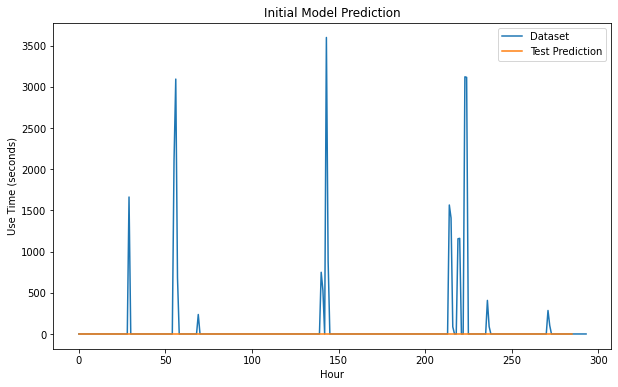

Epoch 1/100
577/577 - 2s - loss: 39260.4727 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 16745.2832 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 12755.3877 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 10763.8408 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 9447.9170 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 8554.1064 - accuracy: 0.9454 - 716ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 7841.6235 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 7304.1440 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 6827.8784 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 6482.8042 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 6171.1689 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 5895.8

Epoch 95/100
577/577 - 1s - loss: 2064.0901 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: 2047.4597 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: 2050.2485 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: 2030.1265 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 2017.8774 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 2005.8291 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Train Score: 414.12 RMSE
Test Score: 453.16 RMSE


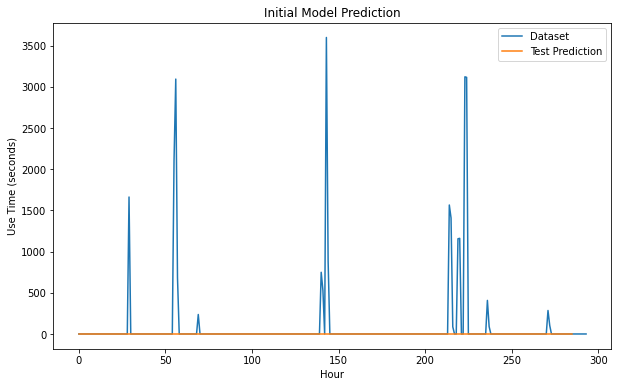

Epoch 1/100
577/577 - 2s - loss: 0.0070 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 657ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 657ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 658ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 663ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 666ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 683ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 673ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 666ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 666ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0063 - accuracy: 0.9454 - 664ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0063 - accuracy: 0.9454 - 668ms/epoch - 1ms/step
Train Score: 399.23 RMSE
Test Score: 435.61 RMSE


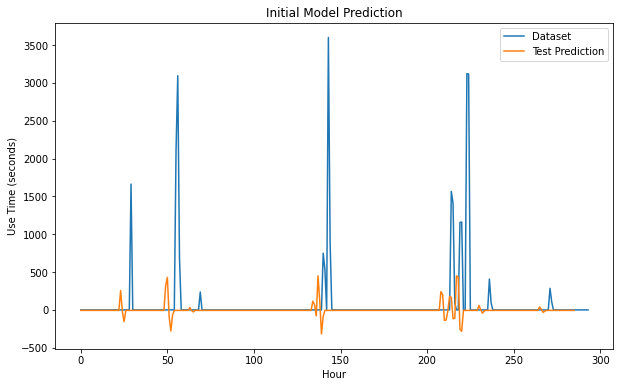

Epoch 1/100
577/577 - 2s - loss: 0.0069 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 696ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 701ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 700ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 700ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 705ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 701ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Train Score: 818.83 RMSE
Test Score: 862.56 RMSE


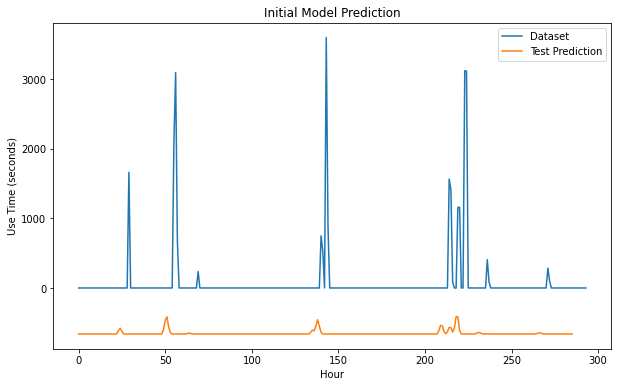

Epoch 1/100
577/577 - 2s - loss: 0.0071 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 706ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 713ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 704ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 702ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Train Score: 471.12 RMSE
Test Score: 482.17 RMSE


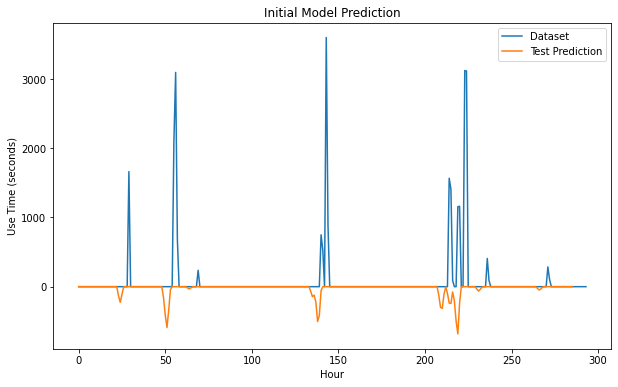

Epoch 1/100
577/577 - 2s - loss: 0.0070 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 700ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 701ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 701ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0070 - accuracy: 0.9454 - 704ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 698ms/epoch - 1ms/step
Train Score: 411.39 RMSE
Test Score: 453.59 RMSE


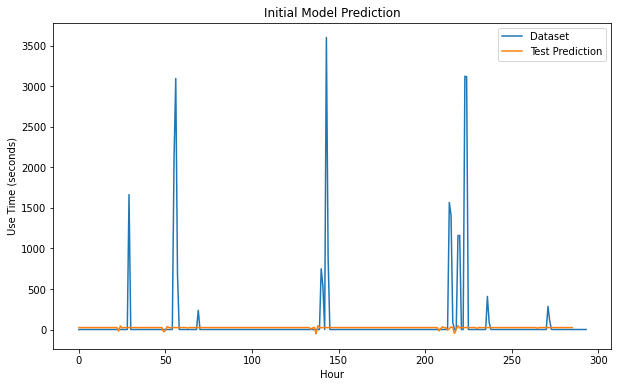

Epoch 1/100
577/577 - 2s - loss: 0.0067 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 686ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 693ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 684ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 684ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 686ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 686ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 684ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Train Score: 396.86 RMSE
Test Score: 434.15 RMSE


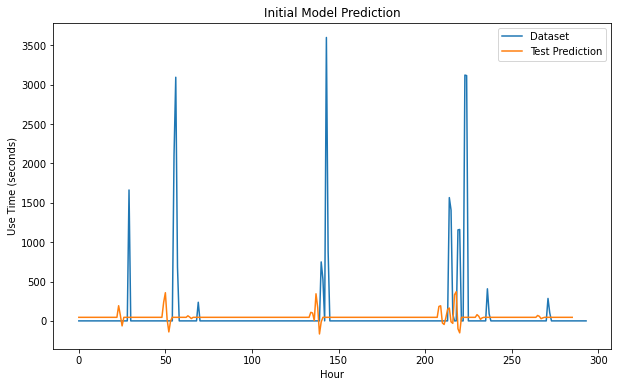

Epoch 1/100
577/577 - 2s - loss: 0.0070 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0069 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0068 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0067 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0067 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0067 - accuracy: 0.9454 - 712ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0067 - accuracy: 0.9454 - 720ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 720ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 714ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 714ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 712ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 715ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9462 - 715ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9462 - 717ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0053 - accuracy: 0.9462 - 715ms/epoch - 1ms/step
Train Score: 361.49 RMSE
Test Score: 410.32 RMSE


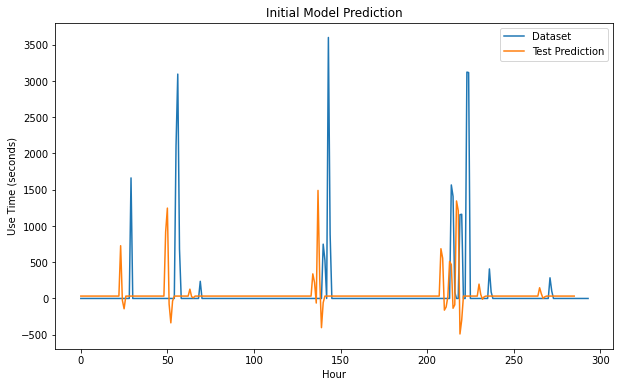

Epoch 1/100
577/577 - 3s - loss: 0.0068 - accuracy: 0.9454 - 3s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 734ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0063 - accuracy: 0.9454 - 733ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0061 - accuracy: 0.9454 - 731ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 731ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0057 - accuracy: 0.9454 - 731ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0056 - accuracy: 0.9454 - 728ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0055 - accuracy: 0.9454 - 733ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 734ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0055 - accuracy: 0.9454 - 733ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9462 - 733ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 730ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9462 - 728ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9471 - 732ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9471 - 727ms/epoch - 1ms/step
Train Score: 425.80 RMSE
Test Score: 472.58 RMSE


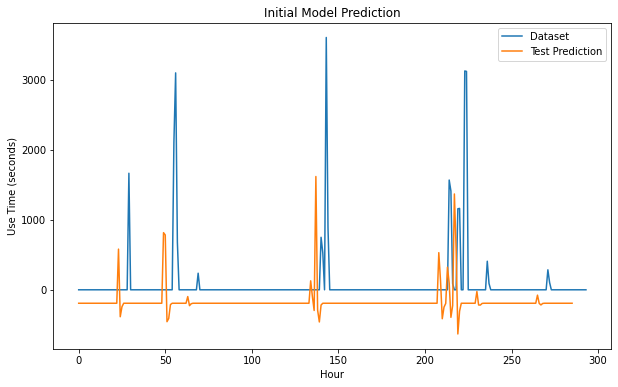

Epoch 1/100
577/577 - 2s - loss: 0.0071 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 711ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 712ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0071 - accuracy: 0.9454 - 712ms/epoch - 1ms/step
Train Score: 414.12 RMSE
Test Score: 453.16 RMSE


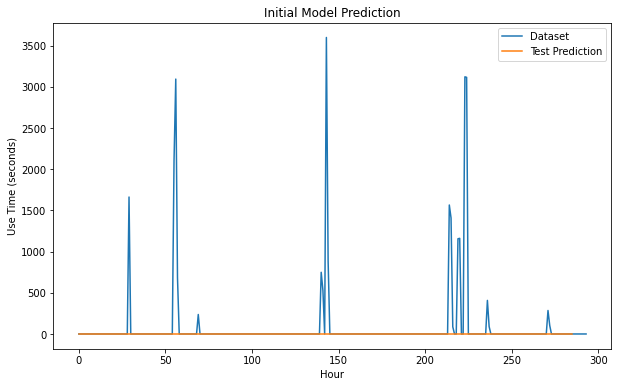

Epoch 1/100
577/577 - 2s - loss: -5.3773e-02 - accuracy: 0.0104 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 666ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 666ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 660ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 661ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 663ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 667ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 665ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 661ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 661ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 663ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 664ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 665ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 655ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 657ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 656ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 657ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 658ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 658ms/epoch - 1ms/step
Train Score: 29781181.05 RMSE
Test Score: 29781158.69 RMSE


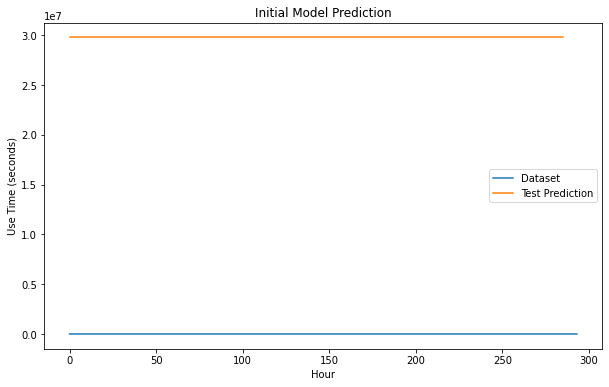

Epoch 1/100
577/577 - 3s - loss: -5.2038e-02 - accuracy: 0.9454 - 3s/epoch - 5ms/step
Epoch 2/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 696ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 700ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9436 - 690ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9402 - 695ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9358 - 692ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.5872 - 710ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 697ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 699ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 698ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 695ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 698ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 695ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 696ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 700ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 697ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 701ms/epoch - 1ms/step
Train Score: 10275.81 RMSE
Test Score: 10245.78 RMSE


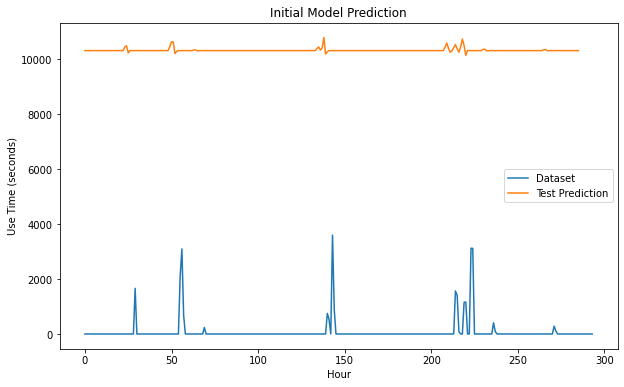

Epoch 1/100
577/577 - 2s - loss: -5.4640e-02 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 713ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 713ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 746ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 767ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 755ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 839ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 707ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 701ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 704ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 709ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 702ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 705ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 701ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 709ms/epoch - 1ms/step
Train Score: 5443.15 RMSE
Test Score: 5422.85 RMSE


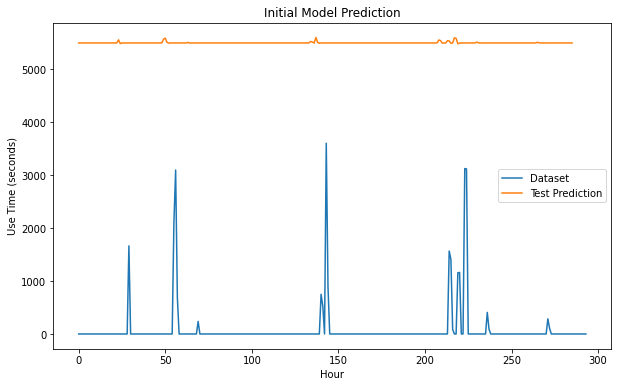

Epoch 1/100
577/577 - 2s - loss: -4.6861e-02 - accuracy: 0.9271 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 698ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 693ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 693ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 698ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 698ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 695ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 693ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 696ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 696ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 701ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 703ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 691ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 691ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 699ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 697ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 697ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 695ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: -4.7702e-02 - accuracy: 0.9271 - 691ms/epoch - 1ms/step
Train Score: 714.39 RMSE
Test Score: 529.90 RMSE


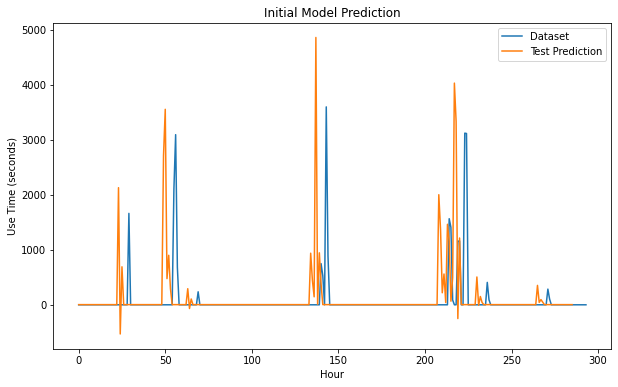

Epoch 1/100
577/577 - 2s - loss: -3.8161e-02 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 681ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 681ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 679ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 684ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 680ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 696ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 685ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 684ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 683ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 686ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 687ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 684ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 682ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: -3.9029e-02 - accuracy: 0.9454 - 685ms/epoch - 1ms/step
Train Score: 436.42 RMSE
Test Score: 442.42 RMSE


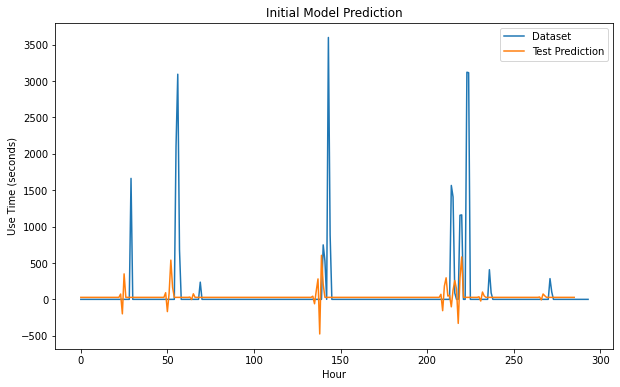

Epoch 1/100
577/577 - 2s - loss: -5.2038e-02 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 706ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 719ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 706ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 706ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 726ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 702ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Train Score: 1198.73 RMSE
Test Score: 1190.58 RMSE


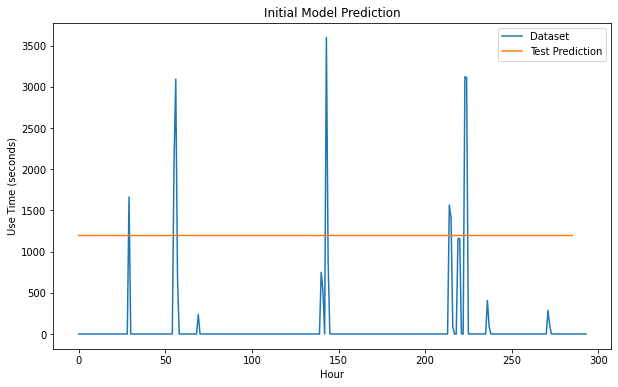

Epoch 1/100
577/577 - 3s - loss: -3.8161e-02 - accuracy: 0.9454 - 3s/epoch - 5ms/step
Epoch 2/100
577/577 - 1s - loss: -2.8621e-02 - accuracy: 0.9454 - 746ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: -2.3417e-02 - accuracy: 0.9454 - 742ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: -2.6886e-02 - accuracy: 0.9454 - 737ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: -2.3417e-02 - accuracy: 0.9454 - 735ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: -2.3417e-02 - accuracy: 0.9454 - 736ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: -2.3417e-02 - accuracy: 0.9454 - 753ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: -2.3417e-02 - accuracy: 0.9454 - 738ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: -2.8621e-02 - accuracy: 0.9454 - 740ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: -4.9436e-02 - accuracy: 0.9454 - 736ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 748ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 745ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 742ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 739ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 750ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9436 - 749ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9393 - 736ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.8378 - 739ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.0061 - 739ms/epoch - 1ms/step
Train Score: 1873.76 RMSE
Test Score: 1859.73 RMSE


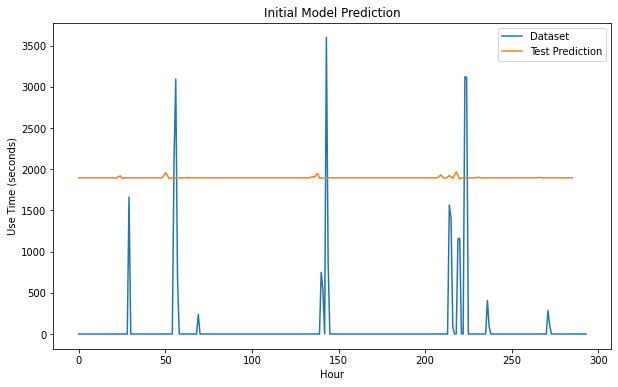

Epoch 1/100
577/577 - 2s - loss: -5.3773e-02 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 714ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 716ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 716ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 720ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 719ms/epoch - 1ms/step
Epoch 12/100
577/577 -

Epoch 93/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 815ms/epoch - 1ms/step
Epoch 94/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 813ms/epoch - 1ms/step
Epoch 95/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 764ms/epoch - 1ms/step
Epoch 96/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 97/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 98/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 723ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: -5.4640e-02 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Train Score: 413.54 RMSE
Test Score: 452.45 RMSE


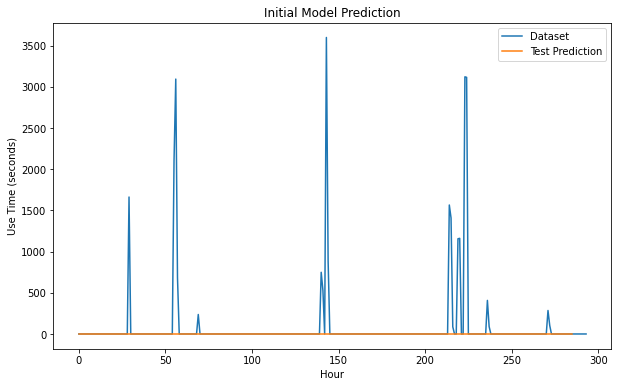

Epoch 1/100
577/577 - 2s - loss: 0.0060 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 668ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 668ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 686ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 685ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 685ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 670ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 668ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 668ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 669ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 669ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 669ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 676ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 674ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 675ms/epoch - 1ms/step
Train Score: 373.66 RMSE
Test Score: 416.31 RMSE


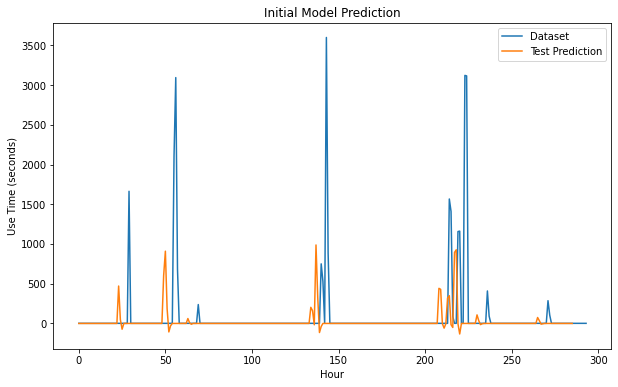

Epoch 1/100
577/577 - 2s - loss: 0.0065 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0063 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0062 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0061 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 714ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0057 - accuracy: 0.9454 - 751ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 773ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0057 - accuracy: 0.9454 - 712ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0049 - accuracy: 0.9462 - 718ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0049 - accuracy: 0.9462 - 720ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0050 - accuracy: 0.9462 - 715ms/epoch - 1ms/step
Train Score: 356.61 RMSE
Test Score: 400.37 RMSE


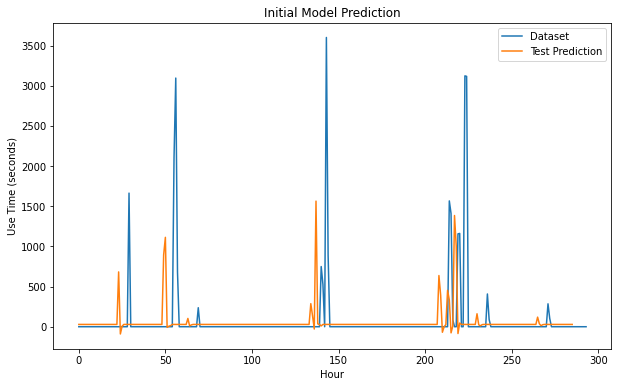

Epoch 1/100
577/577 - 3s - loss: 0.0063 - accuracy: 0.9454 - 3s/epoch - 5ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 719ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0057 - accuracy: 0.9454 - 724ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0056 - accuracy: 0.9454 - 719ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 712ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0053 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0053 - accuracy: 0.9454 - 723ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0051 - accuracy: 0.9454 - 723ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0051 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9454 - 721ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0048 - accuracy: 0.9480 - 758ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0048 - accuracy: 0.9480 - 742ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9480 - 719ms/epoch - 1ms/step
Train Score: 347.98 RMSE
Test Score: 389.09 RMSE


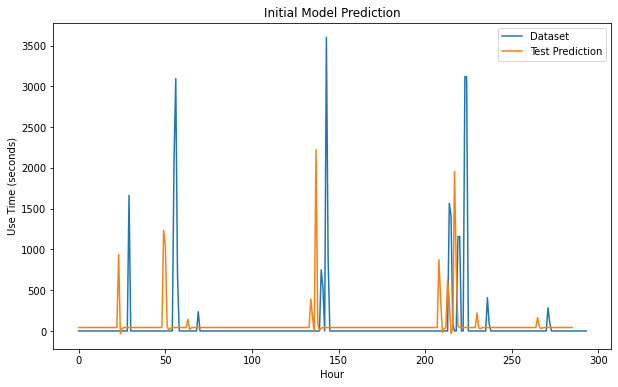

Epoch 1/100
577/577 - 2s - loss: 0.0066 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 713ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 712ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 714ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 712ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 711ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 716ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0066 - accuracy: 0.9454 - 717ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 721ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Train Score: 409.58 RMSE
Test Score: 448.24 RMSE


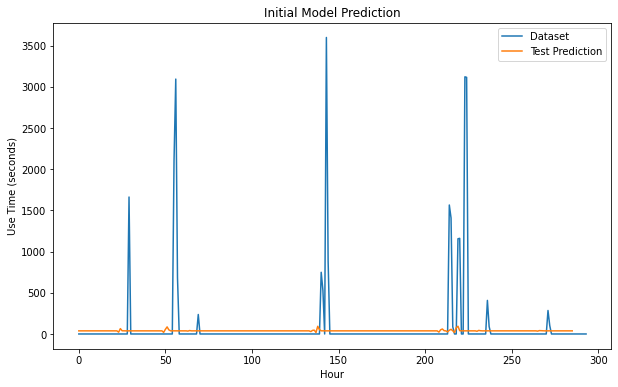

Epoch 1/100
577/577 - 2s - loss: 0.0065 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 719ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 720ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 735ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 720ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 716ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 719ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 720ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 728ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 722ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 725ms/epoch - 1ms/step
Train Score: 408.41 RMSE
Test Score: 444.48 RMSE


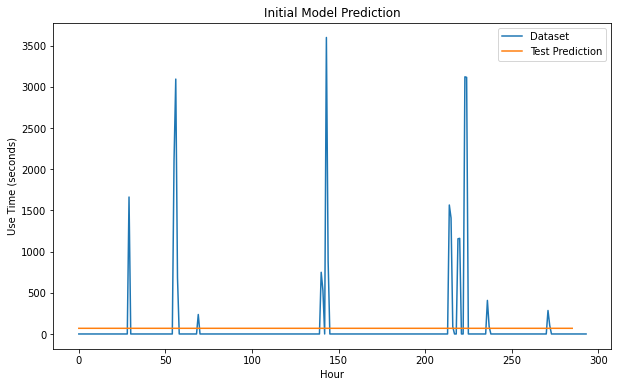

Epoch 1/100
577/577 - 2s - loss: 0.0065 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 727ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 733ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 720ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 727ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 730ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 722ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 722ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 723ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 723ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0050 - accuracy: 0.9454 - 763ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0051 - accuracy: 0.9454 - 721ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0051 - accuracy: 0.9454 - 740ms/epoch - 1ms/step
Train Score: 362.07 RMSE
Test Score: 410.04 RMSE


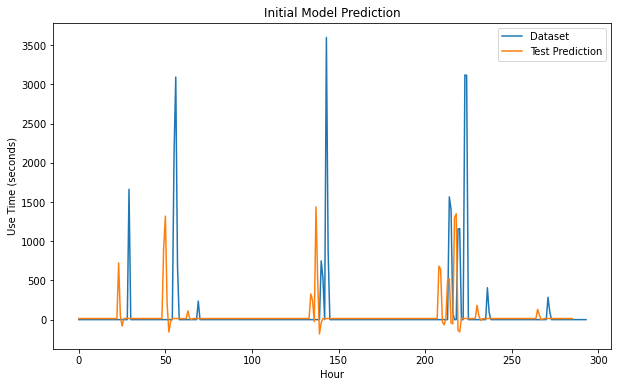

Epoch 1/100
577/577 - 3s - loss: 0.0062 - accuracy: 0.9454 - 3s/epoch - 5ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 744ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0057 - accuracy: 0.9454 - 742ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0056 - accuracy: 0.9454 - 746ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0055 - accuracy: 0.9454 - 745ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0053 - accuracy: 0.9454 - 746ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9454 - 752ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9454 - 751ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9454 - 747ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0051 - accuracy: 0.9454 - 745ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0050 - accuracy: 0.9462 - 744ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0051 - accuracy: 0.9471 - 747ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0048 - accuracy: 0.9480 - 739ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0048 - accuracy: 0.9471 - 751ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0048 - accuracy: 0.9480 - 739ms/epoch - 1ms/step
Train Score: 349.19 RMSE
Test Score: 389.92 RMSE


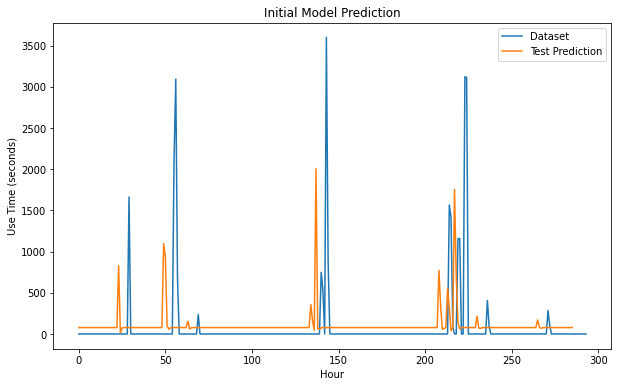

Epoch 1/100
577/577 - 2s - loss: 0.0065 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 719ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0065 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 713ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 719ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 714ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 717ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 721ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0064 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Train Score: 408.37 RMSE
Test Score: 444.48 RMSE


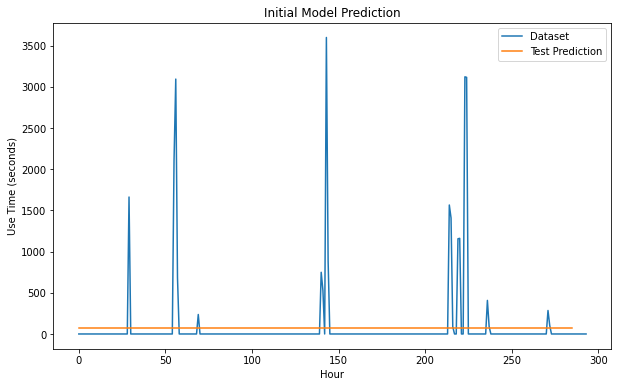

Epoch 1/100
577/577 - 2s - loss: 0.0061 - accuracy: 0.9454 - 2s/epoch - 3ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 667ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 666ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 666ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 663ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 664ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 661ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 660ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 662ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0057 - accuracy: 0.9454 - 665ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0057 - accuracy: 0.9454 - 662ms/epoch - 1ms/step
Train Score: 408.67 RMSE
Test Score: 447.46 RMSE


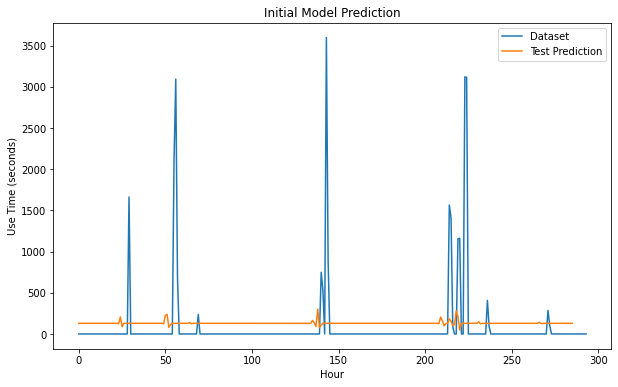

Epoch 1/100
577/577 - 2s - loss: 0.0057 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0057 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0056 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0056 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0056 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0056 - accuracy: 0.9454 - 702ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0055 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 706ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 709ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0053 - accuracy: 0.9454 - 702ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0053 - accuracy: 0.9454 - 703ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0045 - accuracy: 0.9462 - 708ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0045 - accuracy: 0.9462 - 706ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0045 - accuracy: 0.9462 - 708ms/epoch - 1ms/step
Train Score: 358.09 RMSE
Test Score: 397.93 RMSE


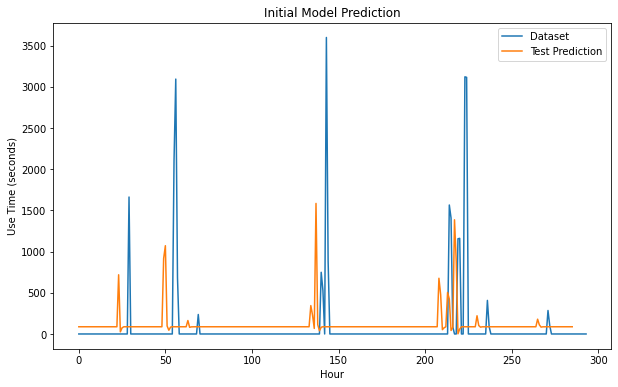

Epoch 1/100
577/577 - 2s - loss: 0.0057 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0056 - accuracy: 0.9454 - 712ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0050 - accuracy: 0.9454 - 715ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0049 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0048 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9454 - 710ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9462 - 715ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9462 - 709ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0046 - accuracy: 0.9462 - 711ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0046 - accuracy: 0.9462 - 708ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0046 - accuracy: 0.9462 - 714ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0043 - accuracy: 0.9480 - 726ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0044 - accuracy: 0.9480 - 709ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0044 - accuracy: 0.9471 - 712ms/epoch - 1ms/step
Train Score: 347.28 RMSE
Test Score: 391.79 RMSE


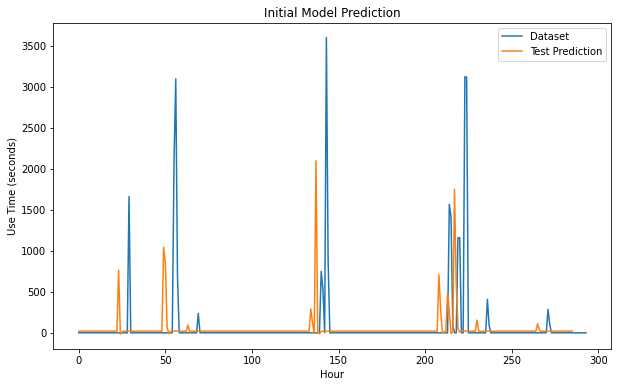

Epoch 1/100
577/577 - 2s - loss: 0.0060 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 694ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 689ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0060 - accuracy: 0.9454 - 696ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 689ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 699ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 690ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 691ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 697ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 691ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 692ms/epoch - 1ms/step
Train Score: 410.19 RMSE
Test Score: 438.88 RMSE


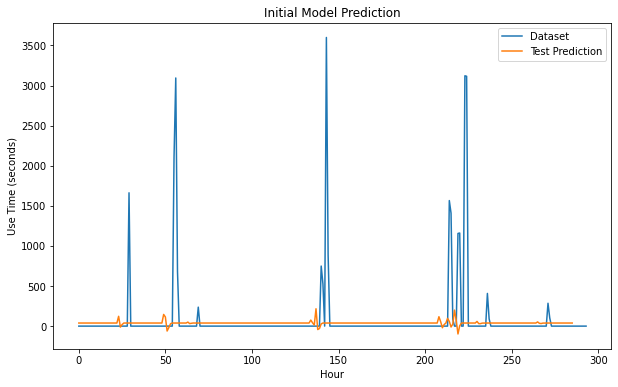

Epoch 1/100
577/577 - 2s - loss: 0.0059 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 683ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 683ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 681ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 678ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 680ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 683ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 679ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 680ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 683ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 678ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 681ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 677ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 674ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 679ms/epoch - 1ms/step
Train Score: 408.45 RMSE
Test Score: 445.03 RMSE


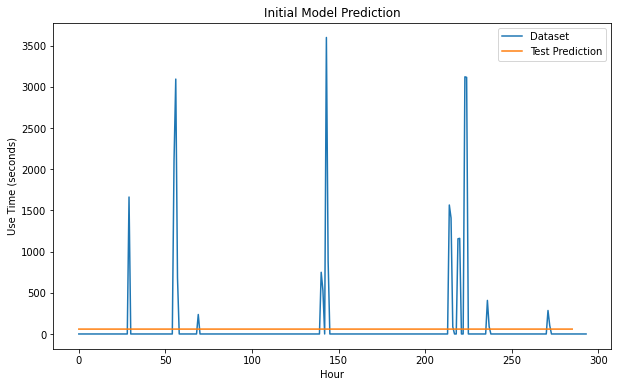

Epoch 1/100
577/577 - 2s - loss: 0.0058 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 704ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 713ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 703ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 713ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 705ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 706ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0046 - accuracy: 0.9454 - 708ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0046 - accuracy: 0.9454 - 707ms/epoch - 1ms/step
Train Score: 361.75 RMSE
Test Score: 406.81 RMSE


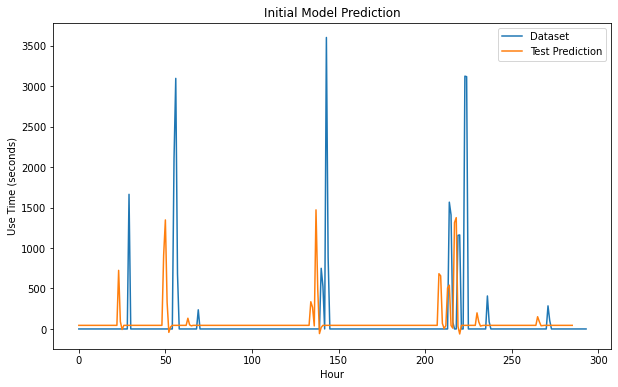

Epoch 1/100
577/577 - 3s - loss: 0.0060 - accuracy: 0.9454 - 3s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0059 - accuracy: 0.9454 - 728ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0057 - accuracy: 0.9454 - 735ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0054 - accuracy: 0.9454 - 726ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0050 - accuracy: 0.9454 - 729ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0049 - accuracy: 0.9454 - 728ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0048 - accuracy: 0.9454 - 732ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9454 - 730ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9454 - 728ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9454 - 729ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0046 - accuracy: 0.9462 - 736ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9462 - 724ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0044 - accuracy: 0.9480 - 727ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0044 - accuracy: 0.9480 - 733ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0044 - accuracy: 0.9480 - 727ms/epoch - 1ms/step
Train Score: 353.53 RMSE
Test Score: 398.10 RMSE


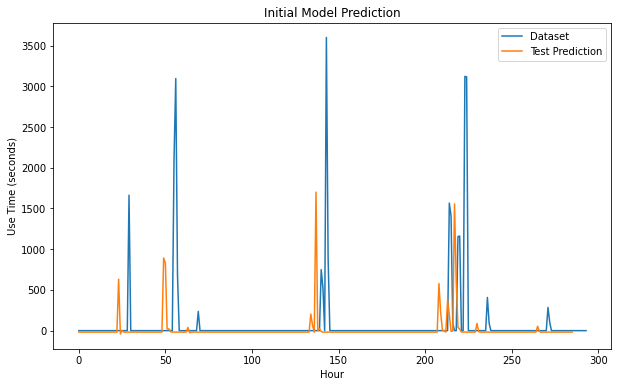

Epoch 1/100
577/577 - 2s - loss: 0.0059 - accuracy: 0.9454 - 2s/epoch - 4ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 729ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 721ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 718ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 721ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 729ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 728ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 720ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 723ms/epoch - 1ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 746ms/epoch - 1

Epoch 98/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 721ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 720ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 717ms/epoch - 1ms/step
Train Score: 408.48 RMSE
Test Score: 445.06 RMSE


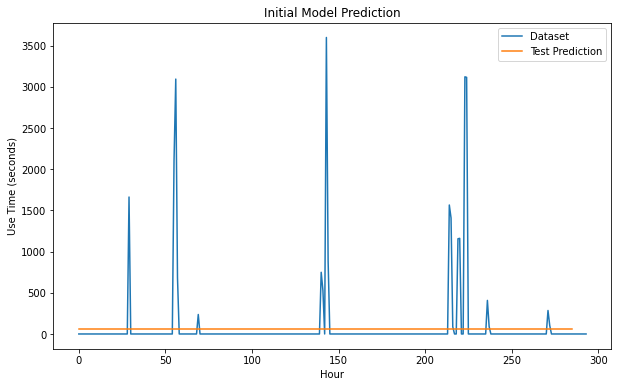

In [61]:
loss = ['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error',
       'mean_squared_logarithmic_error', 'cosine_similarity', 'huber', 'log_cosh']
optimizer = ['SGD', 'RMSprop', 'Adam', 'Adadelta', 'Adagrad', 'Adamax',
            'Nadam', 'Ftrl']

models = defaultdict(object)
testPredictions = defaultdict(object)
testYs = defaultdict(object)

for i in loss:
    for j in optimizer:
        try:
            models[(i, j)], testPredictions[(i, j)], testYs[(i, j)] = basic_LSTM(lookback = 3, num_inputs = 2, batch_size = 2,
                                                                                density = 5, loss = i, optimizer = j)
        except:
            continue

In [67]:
for i in testPredictions:
    accuracy = calculate_accuracy(testPredictions[i], testYs[i][0])
    print(f'{i}\t\taccuracy: {accuracy}')

('mean_squared_error', 'SGD')		accuracy: 0.9090909090909091
('mean_squared_error', 'RMSprop')		accuracy: 0.9090909090909091
('mean_squared_error', 'Adam')		accuracy: 0.9125874125874126
('mean_squared_error', 'Adadelta')		accuracy: 0.8426573426573427
('mean_squared_error', 'Adagrad')		accuracy: 0.9230769230769231
('mean_squared_error', 'Adamax')		accuracy: 0.8776223776223776
('mean_squared_error', 'Nadam')		accuracy: 0.9020979020979021
('mean_squared_error', 'Ftrl')		accuracy: 0.9300699300699301
('mean_absolute_error', 'SGD')		accuracy: 0.8776223776223776
('mean_absolute_error', 'RMSprop')		accuracy: 0.9300699300699301
('mean_absolute_error', 'Adam')		accuracy: 0.8846153846153846
('mean_absolute_error', 'Adadelta')		accuracy: 0.9300699300699301
('mean_absolute_error', 'Adagrad')		accuracy: 0.8566433566433567
('mean_absolute_error', 'Adamax')		accuracy: 0.9265734265734266
('mean_absolute_error', 'Nadam')		accuracy: 0.8776223776223776
('mean_absolute_error', 'Ftrl')		accuracy: 0.930069930

Epoch 1/100
577/577 - 3s - loss: 0.0062 - accuracy: 0.9454 - 3s/epoch - 5ms/step
Epoch 2/100
577/577 - 1s - loss: 0.0058 - accuracy: 0.9454 - 739ms/epoch - 1ms/step
Epoch 3/100
577/577 - 1s - loss: 0.0056 - accuracy: 0.9454 - 814ms/epoch - 1ms/step
Epoch 4/100
577/577 - 1s - loss: 0.0055 - accuracy: 0.9454 - 822ms/epoch - 1ms/step
Epoch 5/100
577/577 - 1s - loss: 0.0053 - accuracy: 0.9454 - 783ms/epoch - 1ms/step
Epoch 6/100
577/577 - 1s - loss: 0.0052 - accuracy: 0.9454 - 748ms/epoch - 1ms/step
Epoch 7/100
577/577 - 1s - loss: 0.0050 - accuracy: 0.9454 - 773ms/epoch - 1ms/step
Epoch 8/100
577/577 - 1s - loss: 0.0048 - accuracy: 0.9454 - 810ms/epoch - 1ms/step
Epoch 9/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9462 - 813ms/epoch - 1ms/step
Epoch 10/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9462 - 920ms/epoch - 2ms/step
Epoch 11/100
577/577 - 1s - loss: 0.0047 - accuracy: 0.9462 - 789ms/epoch - 1ms/step
Epoch 12/100
577/577 - 1s - loss: 0.0046 - accuracy: 0.9462 - 875ms/epoch - 2

Epoch 98/100
577/577 - 1s - loss: 0.0044 - accuracy: 0.9480 - 712ms/epoch - 1ms/step
Epoch 99/100
577/577 - 1s - loss: 0.0044 - accuracy: 0.9480 - 711ms/epoch - 1ms/step
Epoch 100/100
577/577 - 1s - loss: 0.0043 - accuracy: 0.9480 - 715ms/epoch - 1ms/step
Train Score: 354.95 RMSE
Test Score: 400.36 RMSE


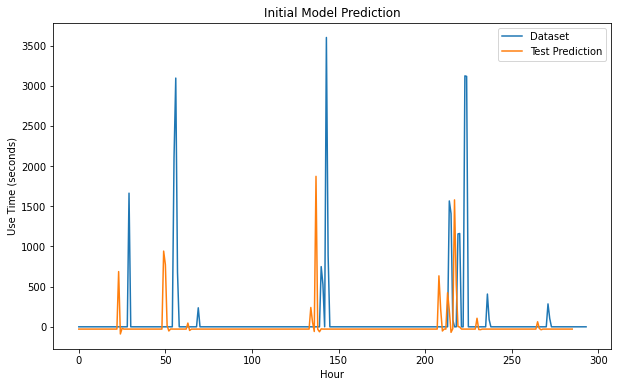

In [68]:
model, testPredict, testY = basic_LSTM(lookback = 3, num_inputs = 2, density = 5, batch_size = 2, epochs = 100,
                                      loss = 'log_cosh', optimizer = 'Nadam')

In [69]:
calculate_accuracy(testPredict, testY[0])

0.9020979020979021

### Encoding 2 (Day Prediction)

In [57]:
df = {'h1': [], 'h2': [], 'h3': [], 'h4': [], 'h5': [], 'h6': [], 'h7': [], 'h8': [], 'h9': [], 'h10': [], 'h11': [], 'h12': [],
      'h13': [], 'h14': [], 'h15': [], 'h16': [], 'h17': [], 'h18': [], 'h19': [], 'h20': [], 'h21': [], 'h22': [], 'h23': [], 'h24': []}
starts = list(range(0, 1448, 24))
for start in starts:
    for i in range(24):
        indx = i + start
        key = list(df.keys())[i]
        if indx < chrome.shape[0]:
            df[key].append(chrome.iloc[indx]['USE_TIME'])
        else:
            df[key].append(0)

In [58]:
day_chrome = pd.DataFrame(df)
day_chrome['day_use'] = day_chrome.sum(axis=1)

In [59]:
day_chrome

,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h16,h17,h18,h19,h20,h21,h22,h23,h24,day_use
0,1896.170,0.000,0.0,0.000,0.000,0.000,3031.022,2209.002,1849.303,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,8985.497
1,0.000,0.000,0.0,74.634,0.000,0.000,0.000,44.355,417.036,287.859,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,907.139
2,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000
3,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000
4,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,1565.922,1565.922
57,1408.135,86.956,0.0,0.000,1155.694,1161.268,0.000,0.000,3122.113,3115.908,...,0.0,0.0,0.0,0.0,0.0,0.0,407.67,89.983,0.000,10547.727
58,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,0.000
59,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,285.175,102.912,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.000,388.087


In [60]:
x_scaler = MinMaxScaler(feature_range=(0, 1))
y_scaler = MinMaxScaler(feature_range=(0, 1))

In [61]:
day_chrome[['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11',
       'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21',
       'h22', 'h23', 'h24']] = x_scaler.fit_transform(day_chrome[['h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11',
       'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21',
       'h22', 'h23', 'h24']])

In [62]:
day_chrome['day_use'] = y_scaler.fit_transform(day_chrome[['day_use']])

In [63]:
dataset = np.array(day_chrome)

In [64]:
day_chrome

,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h16,h17,h18,h19,h20,h21,h22,h23,h24,day_use
0,0.526714,0.000000,0.0,0.000000,0.000000,0.000000,0.841951,0.613612,0.531055,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.851889
1,0.000000,0.000000,0.0,0.021438,0.000000,0.000000,0.000000,0.012321,0.119758,0.092384,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.086003
2,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.946995,0.148461
57,0.391149,0.024154,0.0,0.000000,0.321026,0.442393,0.000000,0.000000,0.896561,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.113242,0.024995,0.000000,1.000000
58,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
59,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.081892,0.033028,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.036793


In [65]:
# split into train and test sets, we want it sequential
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

48 13


In [66]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-1):
        a = dataset[i:(i+look_back), :24]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 24])
    return np.array(dataX), np.array(dataY)

In [67]:
lookback = 1
num_inputs = 24
loss = 'mean_squared_error'
optimizer = 'adam'
epochs = 400
density = 5
batch_size = 1
verbose = 1

In [87]:
trainX, trainY = create_dataset(train, lookback)
testX, testY = create_dataset(test, lookback)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], num_inputs, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], num_inputs, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(16, input_shape=(num_inputs, lookback)))
for i in range(density):
    model.add(Dense(1))
model.compile(loss = loss, optimizer = optimizer, metrics = ['accuracy'])
model.fit(trainX, trainY, epochs = epochs, batch_size = batch_size, verbose = verbose)

Epoch 1/400
47/47 [==============================] - 1s 4ms/step - loss: 0.0828 - accuracy: 0.5319
Epoch 2/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0718 - accuracy: 0.5319
Epoch 3/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0673 - accuracy: 0.5319
Epoch 4/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0681 - accuracy: 0.5319
Epoch 5/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0665 - accuracy: 0.5319
Epoch 6/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0676 - accuracy: 0.5319
Epoch 7/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0678 - accuracy: 0.5319
Epoch 8/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0671 - accuracy: 0.5319
Epoch 9/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0660 - accuracy: 0.5319
Epoch 10/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0666 - accuracy: 0.5319
Epoch 11/

47/47 [==============================] - 0s 4ms/step - loss: 0.0650 - accuracy: 0.5319
Epoch 84/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0656 - accuracy: 0.5319
Epoch 85/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0658 - accuracy: 0.5319
Epoch 86/400
47/47 [==============================] - 0s 3ms/step - loss: 0.0650 - accuracy: 0.5319
Epoch 87/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0654 - accuracy: 0.5319
Epoch 88/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0656 - accuracy: 0.5319
Epoch 89/400
47/47 [==============================] - 0s 3ms/step - loss: 0.0657 - accuracy: 0.5319
Epoch 90/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0656 - accuracy: 0.5319
Epoch 91/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0653 - accuracy: 0.5319
Epoch 92/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0651 - accuracy: 0.5319
Epoch 93/400


47/47 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.5319
Epoch 165/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.5319
Epoch 166/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0653 - accuracy: 0.5319
Epoch 167/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.5319
Epoch 168/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.5319
Epoch 169/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0654 - accuracy: 0.5319
Epoch 170/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0659 - accuracy: 0.5319
Epoch 171/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0653 - accuracy: 0.5319
Epoch 172/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0654 - accuracy: 0.5319
Epoch 173/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0652 - accuracy: 0.5319
Epoc

47/47 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.5319
Epoch 246/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.5319
Epoch 247/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0642 - accuracy: 0.5319
Epoch 248/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0646 - accuracy: 0.5319
Epoch 249/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0643 - accuracy: 0.5319
Epoch 250/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0645 - accuracy: 0.5319
Epoch 251/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0644 - accuracy: 0.5319
Epoch 252/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0644 - accuracy: 0.5319
Epoch 253/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0644 - accuracy: 0.5319
Epoch 254/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0644 - accuracy: 0.5319
Epoc

47/47 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 0.5319
Epoch 327/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0625 - accuracy: 0.5319
Epoch 328/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0626 - accuracy: 0.5319
Epoch 329/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0627 - accuracy: 0.5319
Epoch 330/400
47/47 [==============================] - 0s 3ms/step - loss: 0.0626 - accuracy: 0.5319
Epoch 331/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0627 - accuracy: 0.5319
Epoch 332/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0629 - accuracy: 0.5319
Epoch 333/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0621 - accuracy: 0.5319
Epoch 334/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0611 - accuracy: 0.5319
Epoch 335/400
47/47 [==============================] - 0s 4ms/step - loss: 0.0690 - accuracy: 0.5319
Epoc

Train Score: 2054.88 RMSE
Test Score: 1815.15 RMSE


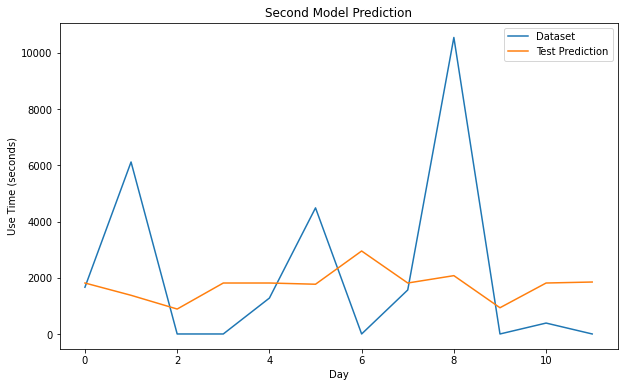

In [88]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# # invert predictions
trainPredict = y_scaler.inverse_transform(trainPredict)
#trainY = y_scaler.inverse_transform([trainY])
testPredict = y_scaler.inverse_transform(testPredict)
#testY = y_scaler.inverse_transform([testY])

# # calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY.reshape(-1, 1), trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY.reshape(-1, 1), testPredict))
print('Test Score: %.2f RMSE' % (testScore))

# # shift train predictions for plotting
# trainPredictPlot = np.empty_like(dataset)
# trainPredictPlot[:, :] = np.nan
# trainPredictPlot[lookback:len(trainPredict)+lookback, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty((61, 1))
testPredictPlot[:, :] = np.nan
testPredictPlot[49:, :] = testPredict
# plot baseline and predictions
fig, ax = plt.subplots()
plt.plot(y_scaler.inverse_transform([day_chrome['day_use']])[0][-12:], label = 'Dataset')
#ax.plot(trainPredict, label = 'Train Prediction')
ax.plot(testPredict, label = 'Test Prediction')
ax.set_xlabel('Day')
ax.set_ylabel('Use Time (seconds)')
ax.set_title('Second Model Prediction')
plt.legend()
plt.show()

In [89]:
calculate_accuracy(testPredict, testY, .5) # scores vary by run

0.25